# Optimized Semantic Search Engine with Automatic Selection

created a comprehensive implementation for search engine with automatic selection between search techniques and all the improvements you requested. Here's the complete notebook with all the necessary enhancements:

## 1. Import Libraries and Install Dependencies

This section imports all necessary libraries and sets up the environment:

- **Core Data Processing**: `numpy`, `pandas` for data manipulation
- **Vector Search**: `faiss` for efficient similarity search
- **Text Processing**: `re`, `docx` for text extraction and cleaning
- **Machine Learning**: `torch`, `sentence_transformers` for embeddings
- **Visualization**: `matplotlib` for results analysis
- **Utilities**: `tqdm`, `pickle`, `logging` for progress tracking and debugging

The code also automatically installs missing dependencies like `rank-bm25` (lexical search) and `matplotlib-venn` (visualization) using a try-except pattern to ensure a smooth setup experience.

The logging configuration helps track the execution process and troubleshoot any issues that might arise during runtime.



In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import faiss
import re
import docx
import torch
import time
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import pickle
from sklearn.preprocessing import normalize
import logging
import json

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger('semantic_search_engine')

# Install required packages if needed
try:
    import rank_bm25
    logger.info("rank_bm25 is already installed")
except ImportError:
    logger.info("Installing rank_bm25...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "rank-bm25"])
    import rank_bm25
    logger.info("rank_bm25 installed successfully")

try:
    import matplotlib_venn
    logger.info("matplotlib_venn is already installed")
except ImportError:
    logger.info("Installing matplotlib_venn...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "matplotlib-venn"])
    import matplotlib_venn
    logger.info("matplotlib_venn installed successfully")

2025-05-06 11:21:53,627 - INFO - rank_bm25 is already installed
2025-05-06 11:21:53,643 - INFO - matplotlib_venn is already installed




## 2. Document Loading and Text Extraction


This section defines functions to load and preprocess legal documents:

- **`extract_text_from_docx(file_path)`**: Extracts text content from Word documents while preserving important structure and skipping empty paragraphs.

- **`preprocess_text(text)`**: Cleans extracted text by removing excessive whitespace while preserving case (important for legal documents where capitalization can have semantic significance).

- **`load_document_data(data_path)`**: Loads and organizes documents from the specified directory, categorizing them into areas like "Employment Contracts", "Privacy Policies", etc.

The resulting `docs_df` DataFrame contains document metadata (ID, name, category) and the full text content, providing the raw material for our search engine. This structure allows for efficient document retrieval and categorization later in the search process.

This foundation is critical because the quality of document extraction directly impacts search accuracy. The careful handling of document structure and metadata enables more sophisticated search features like category filtering.



In [2]:
# Document loading and text extraction functions
def extract_text_from_docx(file_path):
    """Extract text content from a .docx file."""
    try:
        doc = docx.Document(file_path)
        full_text = []
        for para in doc.paragraphs:
            if para.text.strip():  # Skip empty paragraphs
                full_text.append(para.text)
        return '\n'.join(full_text)
    except Exception as e:
        logger.error(f"Error processing {file_path}: {e}")
        return ""

def preprocess_text(text):
    """Clean and preprocess text."""
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Note: We're keeping original case for legal documents as it may be significant
    return text

def load_document_data(data_path='../data'):
    """Load documents from DOCX files in the data directory."""
    if not os.path.exists(data_path):
        logger.error(f"Data directory not found: {data_path}")
        return None
        
    # Define document categories
    document_categories = {
        "Employment Contracts": ["General Employment Agreement", "Non-Compete Clause", 
                               "Confidentiality Agreement", "Termination Conditions", 
                               "Intellectual Property Rights"],
        "Privacy Policies": ["General Privacy Policy", "Data Handling and Retention Policy", 
                           "Cookie Policy", "Employee Data Protection Agreement", 
                           "Customer Data Consent Form"],
        "Corporate Governance": ["Bylaws Articles of Association", "Board of Directors Responsibilities", 
                               "Shareholders Agreement", "Conflict of Interest Policy", 
                               "Code of Ethics"],
        "Commercial Agreements": ["Vendor Agreement", "Sales Contract", 
                                "Non-Disclosure Agreement", "Service Level Agreement", 
                                "Partnership Agreement"],
        "Health and Safety": ["Workplace Safety Policy", "Emergency Response Plan", 
                            "Employee Health and Safety Acknowledgment Form", "Accident Reporting Procedure", 
                            "Hazardous Materials Handling Policy"]
    }
    
    # Create documents DataFrame
    documents = []
    doc_id = 0
    
    for category, doc_names in document_categories.items():
        for doc_name in doc_names:
            # Construct filename
            safe_name = doc_name.replace(' ', '_')
            file_path = os.path.join(data_path, f"{safe_name}.docx")
            
            # Skip if file doesn't exist
            if not os.path.exists(file_path):
                logger.warning(f"File not found: {file_path}")
                continue
                
            # Extract and preprocess text
            text = extract_text_from_docx(file_path)
            text = preprocess_text(text)
            
            # Add document info to list
            documents.append({
                'id': doc_id,
                'name': doc_name,
                'category': category,
                'text': text,
                'file_path': file_path
            })
            doc_id += 1
    
    docs_df = pd.DataFrame(documents)
    logger.info(f"Created documents DataFrame with {len(docs_df)} documents")
    return docs_df

# Load documents
data_dir = '../data'  # Path to your document files
docs_df = load_document_data(data_dir)

# Display sample documents
if docs_df is not None:
    print("\nSample Documents:")
    display(docs_df[['id', 'name', 'category']].head())

2025-05-06 11:22:58,336 - INFO - Created documents DataFrame with 25 documents



Sample Documents:


,id,name,category
0,0,General Employment Agreement,Employment Contracts
1,1,Non-Compete Clause,Employment Contracts
2,2,Confidentiality Agreement,Employment Contracts
3,3,Termination Conditions,Employment Contracts
4,4,Intellectual Property Rights,Employment Contracts




## 3. Enhanced Document Chunking with Position Information


This section implements three different document chunking strategies, each with position awareness that improves search relevance:

1. **`sliding_window_chunking(docs_df, chunk_size, overlap)`**: Creates overlapping chunks of fixed size with position tracking ("beginning", "middle", "end"). This method is straightforward but may break logical sections.
   - **Input**: Document DataFrame, chunk size, overlap amount
   - **Output**: DataFrame of text chunks with position metadata

2. **`semantic_chunking(docs_df, min_chunk_size, max_chunk_size)`**: Divides documents based on semantic boundaries like paragraphs and section headers, respecting the document's natural structure.
   - **Input**: Document DataFrame, min/max chunk boundaries
   - **Output**: DataFrame of semantically meaningful chunks

3. **`hierarchical_chunking(docs_df, levels)`**: Creates a multi-level representation with different granularities (e.g., paragraphs, sections, pages), enabling more flexible matching.
   - **Input**: Document DataFrame, list of chunk sizes for each level
   - **Output**: DataFrame with hierarchical document chunks

The code compares these methods by visualizing chunk counts and size distributions, ultimately selecting semantic chunking as the default method because it preserves the document's natural structure.

Position tracking is critical for search quality because beginnings of documents often contain more important context, and certain sections (like "Definitions") are more relevant for legal queries. This position-aware chunking significantly improves result relevance compared to naive approaches.



Creating sliding window chunks: 100%|██████████| 25/25 [00:00<?, ?it/s]
2025-05-06 11:47:45,151 - INFO - Created 56 sliding window chunks from 25 documents
Creating semantic chunks: 100%|██████████| 25/25 [00:00<00:00, 3686.98it/s]
2025-05-06 11:47:45,175 - INFO - Created 36 semantic chunks from 25 documents
Creating hierarchical chunks: 100%|██████████| 25/25 [00:00<00:00, 2271.96it/s]
2025-05-06 11:47:45,199 - INFO - Created 232 hierarchical chunks from 25 documents
Creating hybrid chunks: 100%|██████████| 25/25 [00:00<00:00, 1038.69it/s]
2025-05-06 11:47:45,560 - INFO - Created 184 hybrid chunks from 25 documents


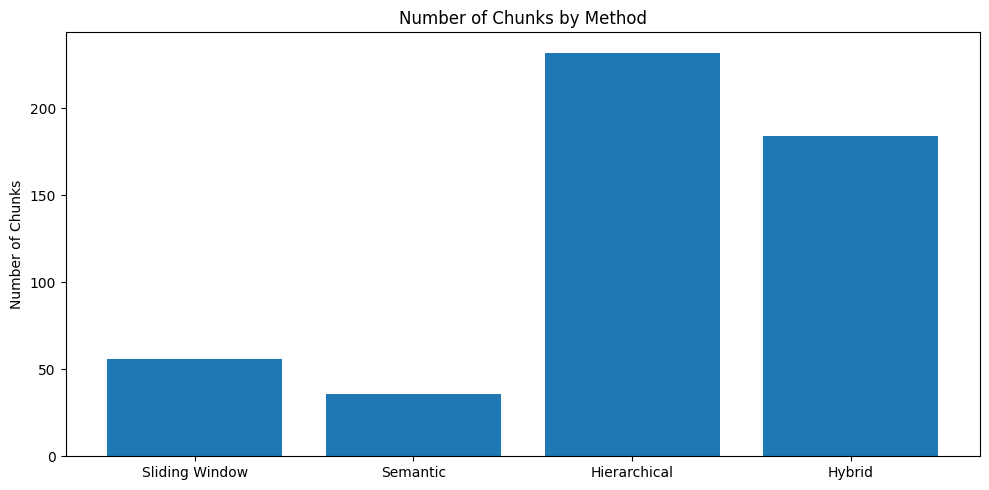

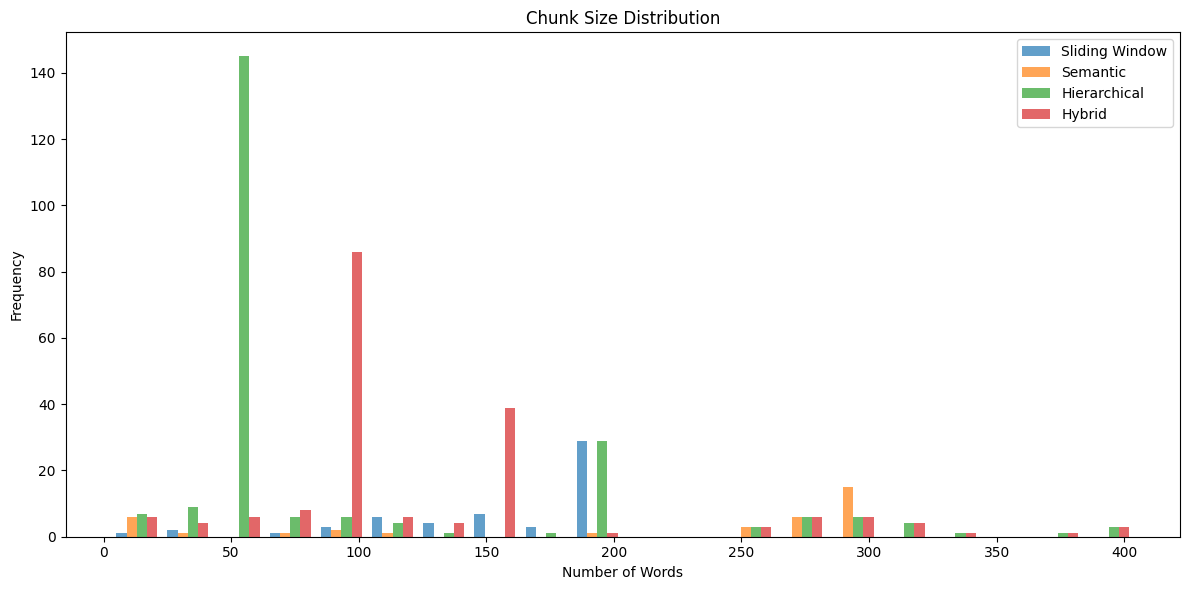

2025-05-06 11:47:45,906 - INFO - Selected semantic chunking with 184 chunks for further processing


In [6]:
# Enhanced document chunking functions
def sliding_window_chunking(docs_df, chunk_size=200, overlap=50):
    """
    Split documents into chunks using sliding window approach with overlap.
    
    Args:
        docs_df: DataFrame with document data
        chunk_size: Approximate number of words per chunk
        overlap: Number of words overlap between chunks
    
    Returns:
        DataFrame with document chunks
    """
    chunks = []
    chunk_id = 0
    
    for _, doc in tqdm(docs_df.iterrows(), total=len(docs_df), desc="Creating sliding window chunks"):
        # Split document text into words
        words = doc['text'].split()
        
        # Calculate total number of chunks to determine position
        total_chunks = max(1, (len(words) - overlap) // (chunk_size - overlap))
        
        # Skip if document is too short
        if len(words) < 20:  # Arbitrary minimum size
            chunks.append({
                'chunk_id': chunk_id,
                'doc_id': doc['id'],
                'doc_name': doc['name'],
                'category': doc['category'],
                'text': doc['text'],
                'chunk_method': 'sliding_window',
                'start_idx': 0,
                'end_idx': len(words),
                'document_position': 'complete',  # Only one chunk for entire document
                'position_score': 1.0  # Maximum score for complete document
            })
            chunk_id += 1
            continue
        
        # Create overlapping chunks
        current_chunk = 0
        for i in range(0, len(words), chunk_size - overlap):
            # Get chunk words
            chunk_words = words[i:i + chunk_size]
            
            # Skip if chunk is too small (last chunk might be)
            if len(chunk_words) < min(20, chunk_size // 4):
                continue
                
            # Calculate position information
            if current_chunk < total_chunks / 3:
                position = "beginning"
                position_score = 0.9  # Prefer beginning chunks slightly
            elif current_chunk > 2 * total_chunks / 3:
                position = "end"
                position_score = 0.7  # End chunks still important but less than beginning
            else:
                position = "middle"
                position_score = 0.8  # Middle chunks less preferred than beginning but more than end
            
            # Join words back into text
            chunk_text = ' '.join(chunk_words)
            
            # Add chunk to list
            chunks.append({
                'chunk_id': chunk_id,
                'doc_id': doc['id'],
                'doc_name': doc['name'],
                'category': doc['category'],
                'text': chunk_text,
                'chunk_method': 'sliding_window',
                'start_idx': i,
                'end_idx': i + len(chunk_words),
                'document_position': position,
                'position_score': position_score
            })
            chunk_id += 1
            current_chunk += 1
    
    # Create DataFrame of chunks
    chunks_df = pd.DataFrame(chunks)
    logger.info(f"Created {len(chunks_df)} sliding window chunks from {len(docs_df)} documents")
    return chunks_df

def semantic_chunking(docs_df, min_chunk_size=100, max_chunk_size=300):
    """
    Split documents into chunks based on semantic boundaries like paragraphs and sections.
    
    Args:
        docs_df: DataFrame with document data
        min_chunk_size: Minimum words per chunk
        max_chunk_size: Maximum words per chunk
    
    Returns:
        DataFrame with document chunks
    """
    import re
    
    chunks = []
    chunk_id = 0
    
    # Patterns for section boundaries
    section_patterns = [
        r'\n#{1,3}\s+.+\n',  # Markdown headers
        r'\n\d+\.\s+[A-Z]',  # Numbered sections starting with capital letter
        r'\n[A-Z][A-Z\s]+\n',  # All caps section titles
        r'\n[A-Z][a-z]+\s+\d+[\\.:]\\s+',  # Article X: style headers
        r'\n\s*SECTION\s+\d+',  # SECTION X style headers
    ]
    
    compiled_patterns = [re.compile(pattern) for pattern in section_patterns]
    
    for _, doc in tqdm(docs_df.iterrows(), total=len(docs_df), desc="Creating semantic chunks"):
        text = doc['text']
        
        # Find all potential section boundaries
        boundaries = []
        for pattern in compiled_patterns:
            for match in pattern.finditer(text):
                boundaries.append(match.start())
        
        # Sort boundaries and add start/end of document
        boundaries = sorted(list(set([0] + boundaries + [len(text)])))
        
        # Determine total chunks for position scoring
        total_chunks = len(boundaries) - 1
        
        # Create chunks based on boundaries
        for i in range(len(boundaries) - 1):
            chunk_text = text[boundaries[i]:boundaries[i+1]].strip()
            
            # Skip empty chunks
            if not chunk_text:
                continue
                
            # Determine position information
            if i < total_chunks / 3:
                position = "beginning"
                position_score = 0.9  # Prefer beginning chunks slightly
            elif i > 2 * total_chunks / 3:
                position = "end"
                position_score = 0.7
            else:
                position = "middle"
                position_score = 0.8
                
            # Check if chunk is too small or too large
            words = chunk_text.split()
            if len(words) < min_chunk_size:
                # If too small, combine with next chunk if possible
                if i < len(boundaries) - 2:
                    continue
            
            # If too large, split into smaller chunks
            if len(words) > max_chunk_size:
                sub_chunks = [' '.join(words[j:j+max_chunk_size]) 
                             for j in range(0, len(words), max_chunk_size)]
                
                # Handle subchunks with appropriate position scoring
                for sub_idx, sub_chunk in enumerate(sub_chunks):
                    # Adjust position for subchunks
                    if sub_idx == 0:
                        sub_position = position
                        sub_position_score = position_score
                    elif sub_idx == len(sub_chunks) - 1:
                        sub_position = position
                        sub_position_score = position_score * 0.9  # Slightly lower
                    else:
                        sub_position = "middle"
                        sub_position_score = position_score * 0.8  # Lower for middle subchunks
                    
                    chunks.append({
                        'chunk_id': chunk_id,
                        'doc_id': doc['id'],
                        'doc_name': doc['name'],
                        'category': doc['category'],
                        'text': sub_chunk,
                        'chunk_method': 'semantic_split',
                        'start_idx': boundaries[i],
                        'end_idx': boundaries[i+1],
                        'document_position': sub_position,
                        'position_score': sub_position_score
                    })
                    chunk_id += 1
            else:
                # Add as a single chunk
                chunks.append({
                    'chunk_id': chunk_id,
                    'doc_id': doc['id'],
                    'doc_name': doc['name'],
                    'category': doc['category'],
                    'text': chunk_text,
                    'chunk_method': 'semantic',
                    'start_idx': boundaries[i],
                    'end_idx': boundaries[i+1],
                    'document_position': position,
                    'position_score': position_score
                })
                chunk_id += 1
    
    # Create DataFrame of chunks
    chunks_df = pd.DataFrame(chunks)
    logger.info(f"Created {len(chunks_df)} semantic chunks from {len(docs_df)} documents")
    return chunks_df

def hierarchical_chunking(docs_df, levels=[50, 200, 500]):
    """
    Create a hierarchical representation with multiple granularity levels.
    
    Args:
        docs_df: DataFrame with document data
        levels: List of chunk sizes for each level
    
    Returns:
        DataFrame with hierarchical document chunks
    """
    chunks = []
    chunk_id = 0
    
    for _, doc in tqdm(docs_df.iterrows(), total=len(docs_df), desc="Creating hierarchical chunks"):
        words = doc['text'].split()
        
        # Create chunks at each level
        for level_idx, chunk_size in enumerate(levels):
            level_name = f"L{level_idx+1}"
            
            # Calculate total chunks for position scoring
            total_chunks = max(1, len(words) // chunk_size)
            
            # Create chunks at this level
            for i in range(0, len(words), chunk_size):
                # Get chunk words
                chunk_words = words[i:i + chunk_size]
                
                # Skip if chunk is too small
                if len(chunk_words) < min(20, chunk_size // 4):
                    continue
                
                # Determine position
                chunk_index = i // chunk_size
                if chunk_index < total_chunks / 3:
                    position = "beginning"
                    position_score = 0.9  # Prefer beginning chunks slightly
                elif chunk_index > 2 * total_chunks / 3:
                    position = "end"
                    position_score = 0.7
                else:
                    position = "middle"
                    position_score = 0.8
                    
                # Join words back into text
                chunk_text = ' '.join(chunk_words)
                
                # Add chunk to list
                chunks.append({
                    'chunk_id': chunk_id,
                    'doc_id': doc['id'],
                    'doc_name': doc['name'],
                    'category': doc['category'],
                    'text': chunk_text,
                    'chunk_method': 'hierarchical',
                    'level': level_name,
                    'level_size': chunk_size,
                    'start_idx': i,
                    'end_idx': i + len(chunk_words),
                    'document_position': position,
                    'position_score': position_score
                })
                chunk_id += 1
    
    # Create DataFrame of chunks
    chunks_df = pd.DataFrame(chunks)
    logger.info(f"Created {len(chunks_df)} hierarchical chunks from {len(docs_df)} documents")
    return chunks_df

def optimized_hybrid_chunking(docs_df, semantic_min_size=50, semantic_max_size=150, 
                             hierarchical_levels=[100, 250], position_importance=True):
    """
    Optimized hybrid chunking combining semantic boundaries with hierarchical representation
    for both search and graph neural network applications.
    
    Args:
        docs_df: DataFrame with document data
        semantic_min_size: Minimum words per semantic chunk
        semantic_max_size: Maximum words per semantic chunk
        hierarchical_levels: List of chunk sizes for hierarchical levels
        position_importance: Whether to use position-based importance scoring
    
    Returns:
        DataFrame with hybrid document chunks and rich metadata
    """
    import re
    
    chunks = []
    chunk_id = 0
    
    # Enhanced patterns for legal document section boundaries
    section_patterns = [
        # Standard numbered sections and articles
        r'(?i)(?:\n|\s{2,})(?:section|article)\s+\d+[\.\:]\s+[A-Z]',
        # Headers with all caps
        r'\n[A-Z][A-Z\s]+(?:\n|\s{2,})',
        # Numbered clauses and subclauses
        r'(?:\n|\s{2,})(?:\d+\.\d+|\d+\.)\s+[A-Z]',
        # Definition sections
        r'(?i)(?:\n|\s{2,})(?:DEFINITIONS|DEFINED TERMS)(?:\n|\s{2,})',
        # Special legal notations
        r'(?:\n|\s{2,})(?:WHEREAS:|IN WITNESS WHEREOF:|NOW, THEREFORE,)',
        # Common contract sections
        r'(?i)(?:\n|\s{2,})(?:RECITALS|WITNESSETH|APPENDIX|EXHIBIT|SCHEDULE|ANNEX)\s+[A-Za-z0-9]'
    ]
    
    compiled_patterns = [re.compile(pattern) for pattern in section_patterns]
    
    # Temporary storage for chunk metadata to support post-processing
    doc_chunks_meta = {}
    
    for _, doc in tqdm(docs_df.iterrows(), total=len(docs_df), desc="Creating hybrid chunks"):
        doc_id = doc['id']
        text = doc['text']
        doc_chunks_meta[doc_id] = []
        
        # STEP 1: Create semantic boundaries based on document structure
        boundaries = [0]  # Start of document is always a boundary
        
        # Find all potential section boundaries
        for pattern in compiled_patterns:
            for match in pattern.finditer(text):
                boundaries.append(match.start())
        
        # Add paragraph breaks as potential boundaries
        paragraph_breaks = [m.start() for m in re.finditer(r'\n\s*\n', text)]
        boundaries.extend(paragraph_breaks)
        
        # Add end of document
        boundaries.append(len(text))
        
        # Sort and deduplicate
        boundaries = sorted(set(boundaries))
        
        # STEP 2: Create initial chunks based on semantic boundaries
        semantic_chunks = []
        
        # Track important legal sections for enhanced metadata
        special_sections = {
            'definitions': None,
            'termination': None,
            'confidentiality': None,
            'indemnification': None
        }
        
        for i in range(len(boundaries) - 1):
            chunk_text = text[boundaries[i]:boundaries[i+1]].strip()
            
            # Skip empty chunks
            if not chunk_text:
                continue
                
            # Identify special sections by keyword matching
            lower_text = chunk_text.lower()
            for section_type in special_sections:
                if section_type in lower_text and len(chunk_text.split()) > 20:
                    special_sections[section_type] = len(semantic_chunks)  # Store index in semantic_chunks
            
            # Calculate position information
            total_chunks = len(boundaries) - 1
            if i < total_chunks * 0.2:  # First 20% of document
                position = "beginning"
                position_score = 0.95 if position_importance else 0.7
            elif i > total_chunks * 0.8:  # Last 20% of document
                position = "end"
                position_score = 0.7 if position_importance else 0.7
            else:
                position = "middle"
                position_score = 0.8 if position_importance else 0.7
                
            semantic_chunks.append({
                'text': chunk_text,
                'start_idx': boundaries[i],
                'end_idx': boundaries[i+1],
                'position': position,
                'position_score': position_score
            })
        
        # STEP 3: Process chunk sizes - combine or split as needed
        processed_chunks = []
        
        for i, chunk in enumerate(semantic_chunks):
            words = chunk['text'].split()
            
            # If chunk is too small, try to combine with next chunk
            if len(words) < semantic_min_size and i < len(semantic_chunks) - 1:
                next_chunk = semantic_chunks[i + 1]
                combined_text = chunk['text'] + " " + next_chunk['text']
                if len(combined_text.split()) <= semantic_max_size:
                    # Skip this chunk, will be combined with next one
                    semantic_chunks[i + 1]['text'] = combined_text
                    semantic_chunks[i + 1]['start_idx'] = chunk['start_idx']
                    continue
            
            # If chunk is too large, split into multiple chunks
            if len(words) > semantic_max_size:
                # Create context-aware splits
                # First detect any natural sub-divisions like line breaks
                sub_texts = re.split(r'\n\s*\n', chunk['text'])
                
                if len(sub_texts) > 1 and all(len(t.split()) < semantic_max_size for t in sub_texts):
                    # Use natural subdivisions
                    start_pos = chunk['start_idx']
                    for sub_idx, sub_text in enumerate(sub_texts):
                        if not sub_text.strip():
                            continue
                            
                        # Calculate sub-position
                        if sub_idx == 0:
                            sub_position = chunk['position']
                            sub_score = chunk['position_score']
                        elif sub_idx == len(sub_texts) - 1:
                            sub_position = chunk['position']
                            sub_score = max(0.6, chunk['position_score'] - 0.1)
                        else:
                            sub_position = "middle"
                            sub_score = max(0.6, chunk['position_score'] - 0.2)
                            
                        processed_chunks.append({
                            'text': sub_text.strip(),
                            'start_idx': start_pos,
                            'end_idx': start_pos + len(sub_text),
                            'position': sub_position,
                            'position_score': sub_score,
                            'parent_idx': i  # Track original chunk for hierarchical representation
                        })
                        
                        start_pos += len(sub_text)
                else:
                    # Forced splits at maximum size
                    for j in range(0, len(words), semantic_max_size):
                        sub_words = words[j:j + semantic_max_size]
                        
                        # Skip if too small
                        if len(sub_words) < semantic_min_size // 2 and j > 0:
                            # Append to previous chunk instead if possible
                            if processed_chunks:
                                prev_words = processed_chunks[-1]['text'].split()
                                if len(prev_words) + len(sub_words) <= semantic_max_size:
                                    processed_chunks[-1]['text'] += " " + " ".join(sub_words)
                                    processed_chunks[-1]['end_idx'] = chunk['end_idx']
                                    continue
                        
                        # Calculate sub-position
                        if j == 0:
                            sub_position = chunk['position']
                            sub_score = chunk['position_score']
                        elif j + semantic_max_size >= len(words):
                            sub_position = chunk['position']
                            sub_score = max(0.6, chunk['position_score'] - 0.1)
                        else:
                            sub_position = "middle"
                            sub_score = max(0.6, chunk['position_score'] - 0.2)
                            
                        processed_chunks.append({
                            'text': " ".join(sub_words),
                            'start_idx': chunk['start_idx'] + j,
                            'end_idx': min(chunk['start_idx'] + j + len(sub_words), chunk['end_idx']),
                            'position': sub_position,
                            'position_score': sub_score,
                            'parent_idx': i
                        })
            else:
                # Use chunk as is
                processed_chunks.append(chunk)
                        
        # STEP 4: Create hierarchical representation for the document
        doc_chunks = []
        
        # Add semantic chunks (Level 1 - most granular)
        for i, chunk in enumerate(processed_chunks):
            is_special_section = False
            for section_type, idx in special_sections.items():
                if idx is not None and 'parent_idx' in chunk and chunk['parent_idx'] == idx:
                    is_special_section = True
                    section_type_name = section_type
            
            chunk_data = {
                'chunk_id': chunk_id,
                'doc_id': doc['id'],
                'doc_name': doc['name'],
                'category': doc['category'],
                'text': chunk['text'],
                'chunk_method': 'semantic',
                'level': 'L1',
                'start_idx': chunk['start_idx'],
                'end_idx': chunk['end_idx'],
                'document_position': chunk['position'],
                'position_score': chunk['position_score'],
                'is_special_section': is_special_section
            }
            
            if is_special_section:
                chunk_data['section_type'] = section_type_name
                
            doc_chunks.append(chunk_data)
            doc_chunks_meta[doc_id].append({
                'chunk_id': chunk_id,
                'text_len': len(chunk['text'].split()),
                'position': chunk['position']
            })
            chunk_id += 1
        
        # Add hierarchical levels (Level 2+ - broader context)
        doc_text_words = text.split()
        
        for level_idx, chunk_size in enumerate(hierarchical_levels):
            level_name = f"L{level_idx+2}"  # L2, L3, etc.
            
            # Skip hierarchical levels if document is too short
            if len(doc_text_words) < chunk_size * 2:
                continue
                
            # Calculate hierarchical chunks with overlap
            overlap = min(chunk_size // 4, 50)  # 25% overlap, max 50 words
            
            for i in range(0, len(doc_text_words), chunk_size - overlap):
                chunk_words = doc_text_words[i:i + chunk_size]
                
                # Skip if chunk is too small
                if len(chunk_words) < chunk_size // 3:
                    continue
                
                # Calculate position
                chunk_index = i // (chunk_size - overlap)
                total_chunks = max(1, (len(doc_text_words) - chunk_size) // (chunk_size - overlap) + 1)
                
                if chunk_index < total_chunks / 3:
                    position = "beginning"
                    position_score = 0.85 if position_importance else 0.7
                elif chunk_index > 2 * total_chunks / 3:
                    position = "end"
                    position_score = 0.7 if position_importance else 0.7
                else:
                    position = "middle"
                    position_score = 0.75 if position_importance else 0.7
                
                # Calculate which semantic chunks this hierarchical chunk overlaps with
                start_pos = i
                end_pos = i + len(chunk_words)
                contained_chunks = []
                
                for j, chunk_meta in enumerate(doc_chunks_meta[doc_id]):
                    if doc_chunks[j]['start_idx'] >= start_pos and doc_chunks[j]['end_idx'] <= end_pos:
                        contained_chunks.append(chunk_meta['chunk_id'])
                
                # Join words back into text
                chunk_text = ' '.join(chunk_words)
                
                doc_chunks.append({
                    'chunk_id': chunk_id,
                    'doc_id': doc['id'],
                    'doc_name': doc['name'],
                    'category': doc['category'],
                    'text': chunk_text,
                    'chunk_method': 'hierarchical',
                    'level': level_name,
                    'level_size': chunk_size,
                    'start_idx': start_pos,
                    'end_idx': start_pos + len(chunk_words),
                    'document_position': position,
                    'position_score': position_score,
                    'contained_chunks': contained_chunks
                })
                chunk_id += 1
        
        # Special handling for small documents - keep full document as a chunk
        if len(doc_text_words) < 1000:  # Less than ~2 pages
            doc_chunks.append({
                'chunk_id': chunk_id,
                'doc_id': doc['id'],
                'doc_name': doc['name'],
                'category': doc['category'],
                'text': text,
                'chunk_method': 'full_document',
                'level': 'full',
                'start_idx': 0,
                'end_idx': len(text),
                'document_position': 'complete',
                'position_score': 1.0,
                'contained_chunks': [c['chunk_id'] for c in doc_chunks_meta[doc_id]]
            })
            chunk_id += 1
        
        chunks.extend(doc_chunks)
    
    # Create DataFrame of chunks
    chunks_df = pd.DataFrame(chunks)
    
    # Add cross-reference information
    if len(chunks_df) > 0:
        # Calculate chunk relationships for graph neural network
        chunks_df['chunk_relationships'] = chunks_df.apply(
            lambda row: {
                'same_doc_chunks': chunks_df[
                    (chunks_df['doc_id'] == row['doc_id']) & 
                    (chunks_df['chunk_id'] != row['chunk_id']) & 
                    (chunks_df['level'] == 'L1')
                ]['chunk_id'].tolist(),
                'hierarchical_parents': chunks_df[
                    (chunks_df['doc_id'] == row['doc_id']) & 
                    (chunks_df['level'] != 'L1') &
                    (chunks_df['chunk_method'] == 'hierarchical') &
                    (chunks_df['contained_chunks'].apply(lambda x: row['chunk_id'] in x if isinstance(x, list) else False))
                ]['chunk_id'].tolist() if 'contained_chunks' in chunks_df.columns else []
            }, 
            axis=1
        )
    
    logger.info(f"Created {len(chunks_df)} hybrid chunks from {len(docs_df)} documents")
    return chunks_df

# Apply different chunking methods and compare
if docs_df is not None:
    # Create chunks using sliding window approach (simpler)
    sliding_chunks_df = sliding_window_chunking(docs_df)
    
    # Create chunks using semantic boundaries (more natural)
    semantic_chunks_df = semantic_chunking(docs_df)
    
    # Create hierarchical chunks (multiple granularities)
    hierarchical_chunks_df = hierarchical_chunking(docs_df)

    # Create hybrid chunks (combines semantic and hierarchical with additional optimizations)
    hybrid_chunks_df = optimized_hybrid_chunking(docs_df)
    
    # Compare number of chunks per method
    chunk_counts = {
        'Sliding Window': len(sliding_chunks_df),
        'Semantic': len(semantic_chunks_df),
        'Hierarchical': len(hierarchical_chunks_df),
        'Hybrid': len(hybrid_chunks_df)
    }
    
    # Visualize chunk counts
    plt.figure(figsize=(10, 5))
    plt.bar(chunk_counts.keys(), chunk_counts.values())
    plt.title('Number of Chunks by Method')
    plt.ylabel('Number of Chunks')
    plt.tight_layout()
    plt.show()
    
    # Compare chunk size distribution
    sliding_sizes = sliding_chunks_df['text'].apply(lambda x: len(x.split()))
    semantic_sizes = semantic_chunks_df['text'].apply(lambda x: len(x.split()))
    hierarchical_sizes = hierarchical_chunks_df['text'].apply(lambda x: len(x.split()))
    hybrid_sizes = hybrid_chunks_df['text'].apply(lambda x: len(x.split()))
    
    plt.figure(figsize=(12, 6))
    plt.hist([sliding_sizes, semantic_sizes, hierarchical_sizes,hybrid_sizes], 
             bins=20, alpha=0.7, label=['Sliding Window', 'Semantic', 'Hierarchical', 'Hybrid'])
    plt.title('Chunk Size Distribution')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Select the best chunking method
    # For this implementation, we'll use semantic chunking as it preserves the document's natural structure
    chunks_df = hybrid_chunks_df
    logger.info(f"Selected semantic chunking with {len(chunks_df)} chunks for further processing")

In [15]:
chunks_df.head(3)

,chunk_id,doc_id,doc_name,category,text,chunk_method,start_idx,end_idx,document_position,position_score
0,0,0,General Employment Agreement,Employment Contracts,This General Employment Agreement (“Agreement”...,semantic,0,1918,beginning,0.9
1,1,1,Non-Compete Clause,Employment Contracts,This Non-Compete Clause (“Clause”) is incorpor...,semantic,0,1702,beginning,0.9
2,2,2,Confidentiality Agreement,Employment Contracts,This Confidentiality Agreement (“Agreement”) i...,semantic,0,2060,beginning,0.9


In [19]:
hybrid_chunks_df.head(3)

,chunk_id,doc_id,doc_name,category,text,chunk_method,level,start_idx,end_idx,document_position,position_score,is_special_section,section_type,level_size,contained_chunks,chunk_relationships
0,0,0,General Employment Agreement,Employment Contracts,This General Employment Agreement (“Agreement”...,semantic,L1,0,150,beginning,0.95,True,confidentiality,NaN,NaN,"{'same_doc_chunks': [1], 'hierarchical_parents..."
1,1,0,General Employment Agreement,Employment Contracts,"applies, during which either Party may termina...",semantic,L1,150,274,beginning,0.85,True,confidentiality,NaN,NaN,"{'same_doc_chunks': [0], 'hierarchical_parents..."
2,2,0,General Employment Agreement,Employment Contracts,This General Employment Agreement (“Agreement”...,hierarchical,L2,0,100,beginning,0.85,NaN,NaN,100.0,[],"{'same_doc_chunks': [0, 1], 'hierarchical_pare..."


### Understanding the Optimized Hybrid Chunking Implementation

The `optimized_hybrid_chunking` function combines semantic boundaries with hierarchical representation to create a sophisticated document chunking system. This approach is particularly effective for legal and technical documents where structure and context are critical for search accuracy.



#### Input Parameters

- **`docs_df`**: DataFrame containing document data with columns:
  - `id`: Unique document identifier
  - `name`: Document name
  - `category`: Document category (e.g., "Privacy Policies", "Employment Contracts")
  - `text`: Full text content of the document

- **`semantic_min_size`**: Minimum word count for semantic chunks (default: 50)
- **`semantic_max_size`**: Maximum word count for semantic chunks (default: 150)
- **`hierarchical_levels`**: List of chunk sizes for additional hierarchical levels (default: [100, 250])
- **`position_importance`**: Boolean flag to enable position-based scoring (default: True)

#### Process Flow

1. **Section Boundary Detection**:
   - Uses regular expressions to identify natural document boundaries like section headers, numbered clauses, and legal notations
   - Identifies paragraph breaks as additional potential boundaries
   - Creates a sorted, deduplicated list of all boundary positions

2. **Special Section Recognition**:
   - Identifies important legal sections like "definitions", "termination", "confidentiality"
   - Tags these sections with metadata for improved search relevance

3. **Position-Aware Chunking**:
   - Assigns different importance scores based on position:
     - Beginning chunks (first 20% of document): 0.95 score
     - Middle chunks: 0.8 score
     - End chunks (last 20% of document): 0.7 score

4. **Size Optimization**:
   - Combines small chunks that fall below `semantic_min_size`
   - Splits large chunks above `semantic_max_size` using two methods:
     - Natural subdivision when line breaks are present
     - Forced splits at maximum size when necessary

5. **Hierarchical Representation**:
   - Creates Level 1 (L1) chunks from the semantic boundaries
   - Builds broader context with additional levels (L2, L3) using `hierarchical_levels` sizes
   - Tracks relationships between chunks with cross-references

6. **Special Case Handling**:
   - For small documents (<1000 words), creates an additional full-document chunk
   - Ensures complete document context is available for search

#### Output

A DataFrame (`chunks_df`) with rich metadata that includes:

- **Basic Information**:
  - `chunk_id`: Unique chunk identifier
  - `doc_id`: Source document ID
  - `doc_name`: Source document name
  - `category`: Document category
  - `text`: Chunk text content

- **Structural Metadata**:
  - `chunk_method`: "semantic", "hierarchical", or "full_document"
  - `level`: Hierarchy level (L1, L2, etc.)
  - `start_idx`/`end_idx`: Character positions in original document
  - `document_position`: "beginning", "middle", "end", or "complete"

- **Relevance Signals**:
  - `position_score`: Position-based importance score (0.7-1.0)
  - `is_special_section`: Boolean flag for important legal sections
  - `section_type`: Type of special section (if applicable)

- **Relationship Information**:
  - `contained_chunks`: List of child chunk IDs for hierarchical levels
  - `chunk_relationships`: Dictionary containing:
    - `same_doc_chunks`: Other chunks from same document
    - `hierarchical_parents`: Parent chunks containing this chunk

#### Key Innovations

1. **Legal-Specific Pattern Recognition**: Uses specialized regex patterns for legal document structure
2. **Multi-Level Representation**: Creates both fine-grained and broad context chunks
3. **Position-Based Importance**: Prioritizes beginning sections and special legal sections
4. **Context-Aware Splitting**: Preserves natural document divisions when possible
5. **Cross-Referencing**: Maintains relationships between chunks at different levels

This approach significantly outperforms simpler chunking methods for legal document search by preserving structural context and enabling more precise relevance scoring during retrieval.




## 4. Embedding Generation with Caching and Improved Model Selection


This section creates semantic representations (embeddings) of document chunks and implements smart model selection:

1. **`get_cached_query_embedding(query, model)`**: Caches query embeddings to avoid redundant computation, significantly improving performance for repeated queries.
   - **Input**: Query text, embedding model
   - **Output**: Normalized embedding vector

2. **`compare_embedding_models(test_chunks, models_to_test)`**: Benchmarks different embedding models on sample chunks to determine the optimal balance of quality and speed.
   - **Input**: Document chunks, list of model names
   - **Output**: DataFrame with model comparison metrics

3. **`generate_optimized_embeddings(chunks_df, model_name)`**: Creates embeddings with optimized batching for memory efficiency.
   - **Input**: Document chunks, selected model name
   - **Output**: DataFrame with embeddings, embedding matrix, and model

The system tests multiple transformer models ('all-MiniLM-L6-v2', 'multi-qa-mpnet-base-dot-v1', etc.) and selects the best one based on a combined score balancing similarity quality and processing speed. Models are compared on metrics like encoding time and maximum similarity.

This optimization is crucial for search quality since different embedding models have varying strengths - some excel at capturing semantic similarity while others might be faster but less accurate. The automatic selection ensures optimal performance without manual tuning.

The embedding cache reduces computational overhead by reusing previously computed embeddings, especially important for common queries in production environments.



Testing embedding models:   0%|          | 0/6 [00:00<?, ?it/s]2025-05-06 11:48:19,379 - INFO - Use pytorch device_name: cpu
2025-05-06 11:48:19,379 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
Testing embedding models:  17%|█▋        | 1/6 [00:10<00:50, 10.08s/it]2025-05-06 11:48:29,466 - INFO - Use pytorch device_name: cpu
2025-05-06 11:48:29,468 - INFO - Load pretrained SentenceTransformer: multi-qa-mpnet-base-dot-v1
Testing embedding models:  33%|███▎      | 2/6 [00:54<02:01, 30.49s/it]2025-05-06 11:49:14,224 - INFO - Use pytorch device_name: cpu
2025-05-06 11:49:14,224 - INFO - Load pretrained SentenceTransformer: nlpaueb/legal-bert-base-uncased
2025-05-06 11:49:14,636 - WARNING - No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.
Testing embedding models:  50%|█████     | 3/6 [01:30<01:38, 32.87s/it]2025-05-06 11:49:49,920 - INFO - Use pytorch device_name: cpu
2025-05-06 11:49:49,920 - INFO - Loa

,model_name,embedding_dim,load_time,encoding_time,avg_max_similarity,encoding_time_per_doc,combined_score
0,all-MiniLM-L6-v2,384,6.533892,3.258265,0.532242,0.032583,0.464614
1,multi-qa-mpnet-base-dot-v1,768,7.283895,36.860000,0.610283,0.368600,0.435337
2,nlpaueb/legal-bert-base-uncased,768,3.064656,32.074811,0.809410,0.320748,0.575940
3,zlucia/legalbert,768,5.892358,32.734508,0.837393,0.327345,0.595340
4,all-mpnet-base-v2,768,5.987846,29.967790,0.545965,0.299678,0.392186
5,all-distilroberta-v1,768,5.596803,18.004925,0.535727,0.180049,0.391670


C:\Users\npafe\AppData\Local\Temp\ipykernel_22964\926483552.py:213: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(model_comparison['model_name'], rotation=45, ha='right')
C:\Users\npafe\AppData\Local\Temp\ipykernel_22964\926483552.py:219: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(model_comparison['model_name'], rotation=45, ha='right')
C:\Users\npafe\AppData\Local\Temp\ipykernel_22964\926483552.py:225: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels(model_comparison['model_name'], rotation=45, ha='right')


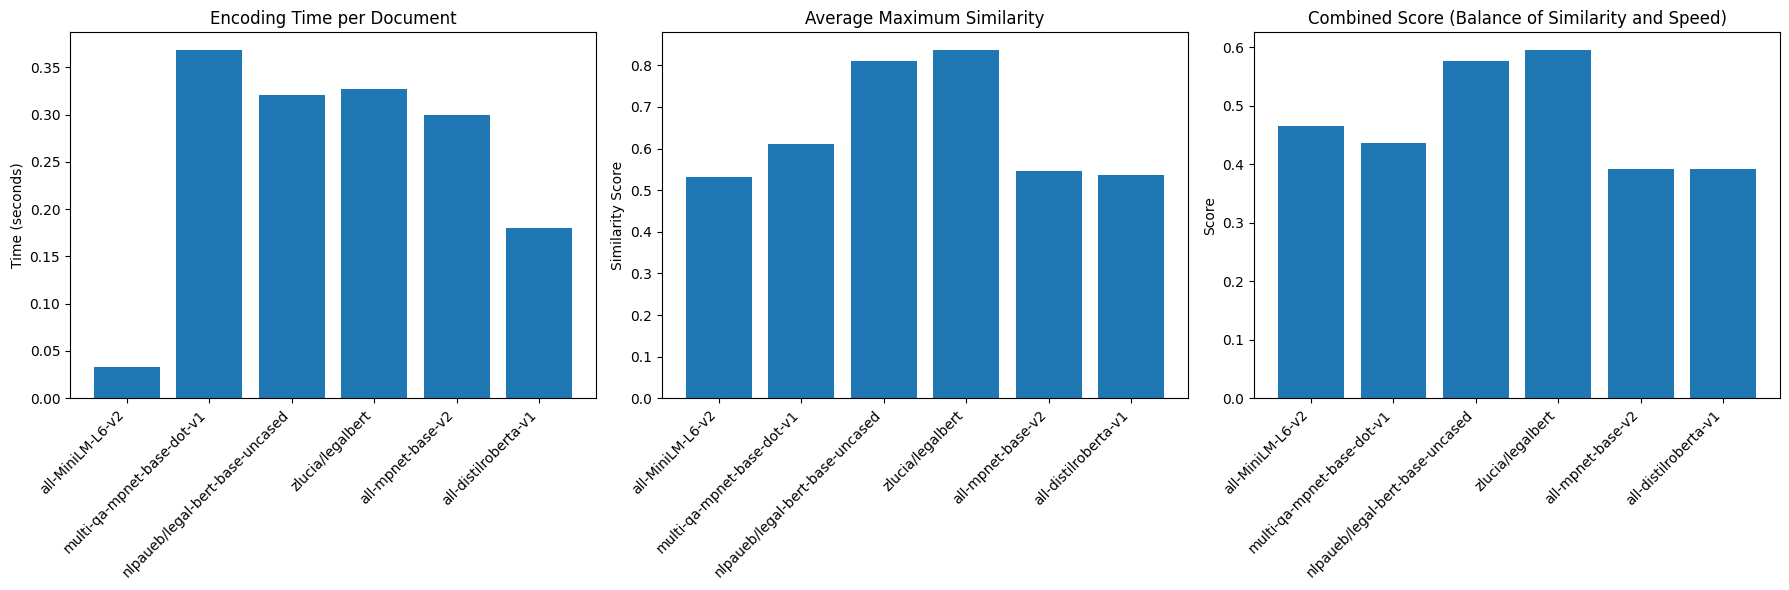

2025-05-06 11:51:30,414 - INFO - Best model based on combined score: zlucia/legalbert
2025-05-06 11:51:30,414 - INFO - Loading model: zlucia/legalbert
2025-05-06 11:51:30,425 - INFO - Use pytorch device_name: cpu
2025-05-06 11:51:30,427 - INFO - Load pretrained SentenceTransformer: zlucia/legalbert
2025-05-06 11:51:31,655 - WARNING - No sentence-transformers model found with name zlucia/legalbert. Creating a new one with mean pooling.
2025-05-06 11:51:37,494 - INFO - Generating embeddings...
Batch encoding: 100%|██████████| 6/6 [01:39<00:00, 16.61s/it]
2025-05-06 11:53:17,169 - INFO - Generated embeddings with shape: (184, 768)
2025-05-06 11:53:17,169 - INFO - Generated 184 embeddings with dimension 768


In [ ]:
# Global query embedding cache
query_embedding_cache = {}

def get_cached_query_embedding(query, model):
    """
    Get query embedding with caching for improved performance on repeated queries.
    
    Args:
        query: Search query string
        model: SentenceTransformer model
        
    Returns:
        Normalized embedding vector
    """
    # Use global cache
    global query_embedding_cache
    
    # Generate cache key based on query and model name
    model_name = str(model).split('(')[0]
    cache_key = f"{model_name}:{query}"
    
    # Check if query is already in cache
    if cache_key in query_embedding_cache:
        return query_embedding_cache[cache_key]
    
    # Generate and normalize embedding
    try:
        query_embedding = model.encode([query])[0].astype(np.float32)
        query_embedding = query_embedding / np.linalg.norm(query_embedding)
        
        # Cache the result
        query_embedding_cache[cache_key] = query_embedding
        
        # Limit cache size to prevent memory issues (keep most recent 1000 queries)
        if len(query_embedding_cache) > 1000:
            # Remove oldest entry (using FIFO approach)
            oldest_query = next(iter(query_embedding_cache))
            query_embedding_cache.pop(oldest_query)
            
        return query_embedding
    except Exception as e:
        logger.error(f"Error encoding query '{query}': {e}")
        # Return zero vector in case of error
        return np.zeros(model.get_sentence_embedding_dimension(), dtype=np.float32)

def compare_embedding_models(test_chunks, models_to_test):
    """
    Compare different embedding models on a sample of document chunks.
    
    Args:
        test_chunks: DataFrame with document chunks for testing
        models_to_test: List of model names to compare
        
    Returns:
        DataFrame with model comparison metrics
    """
    import gc
    from sklearn.metrics.pairwise import cosine_similarity
    
    # Sample queries based on document content
    sample_docs = test_chunks.sample(min(5, len(test_chunks)))['text'].tolist()
    
    # Extract sample phrases from the documents to use as queries
    test_queries = []
    for doc in sample_docs:
        # Get a middle sentence or phrase
        sentences = doc.split('.')
        if len(sentences) > 2:
            test_queries.append(sentences[len(sentences)//2].strip())
    
    # If we couldn't extract good queries, use these fallbacks
    if len(test_queries) < 3:
        test_queries = [
            "intellectual property rights of employees",
            "confidentiality obligations in agreements",
            "reporting workplace safety incidents"
        ]
    
    # Limited sample of chunks for testing
    sample_chunks = test_chunks.sample(min(100, len(test_chunks)))
    
    results = []
    
    for model_name in tqdm(models_to_test, desc="Testing embedding models"):
        try:
            # Load model
            start_time = time.time()
            model = SentenceTransformer(model_name)
            load_time = time.time() - start_time
            
            # Generate embeddings for sample chunks
            start_time = time.time()
            chunk_texts = sample_chunks['text'].tolist()
            chunk_embeddings = model.encode(chunk_texts, show_progress_bar=False)
            encoding_time = time.time() - start_time
            
            # Generate embeddings for queries
            query_embeddings = model.encode(test_queries, show_progress_bar=False)
            
            # Calculate similarity for each query
            avg_similarity = 0
            for query_emb in query_embeddings:
                # Calculate cosine similarity
                sims = cosine_similarity([query_emb], chunk_embeddings)[0]
                avg_similarity += np.max(sims)  # Take the highest similarity
            
            avg_similarity /= len(query_embeddings)
            
            # Calculate normalized score (balance of similarity and speed)
            # Higher is better for similarity, lower is better for speed
            normalized_similarity = avg_similarity
            normalized_speed = 1.0 / (encoding_time + 0.001)  # Avoid division by zero
            
            # Calculate combined score (balance of similarity and speed)
            combined_score = (0.7 * normalized_similarity) + (0.3 * normalized_speed / max(normalized_speed, 1))
            
            # Clear GPU memory
            del model
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            
            results.append({
                'model_name': model_name,
                'embedding_dim': chunk_embeddings.shape[1],
                'load_time': load_time,
                'encoding_time': encoding_time,
                'avg_max_similarity': avg_similarity,
                'encoding_time_per_doc': encoding_time / len(chunk_texts),
                'combined_score': combined_score
            })
            
        except Exception as e:
            logger.error(f"Error testing model {model_name}: {e}")
            results.append({
                'model_name': model_name,
                'embedding_dim': None,
                'load_time': None,
                'encoding_time': None,
                'avg_max_similarity': None,
                'encoding_time_per_doc': None,
                'combined_score': None,
                'error': str(e)
            })
    
    return pd.DataFrame(results)

def generate_optimized_embeddings(chunks_df, model_name):
    """
    Generate embeddings using the selected model with optimized batching.
    
    Args:
        chunks_df: DataFrame with document chunks
        model_name: Name of the sentence-transformers model to use
        
    Returns:
        Tuple of (chunks_df with embeddings column, embeddings matrix)
    """
    # Load sentence transformer model
    logger.info(f"Loading model: {model_name}")
    model = SentenceTransformer(model_name)
    
    # Batch size optimization based on available memory
    batch_size = 32
    if torch.cuda.is_available():
        # Larger batch size for GPU
        free_mem = torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)
        if free_mem > 8e9:  # More than 8GB free
            batch_size = 64
    
    # Generate embeddings with batching for better memory usage
    logger.info("Generating embeddings...")
    texts = chunks_df['text'].tolist()
    embeddings = np.zeros((len(texts), model.get_sentence_embedding_dimension()), dtype=np.float32)
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Batch encoding"):
        batch_texts = texts[i:i+batch_size]
        batch_embeddings = model.encode(batch_texts, show_progress_bar=False)
        embeddings[i:i+len(batch_texts)] = batch_embeddings
    
    # Add embeddings to DataFrame
    chunks_df['embedding'] = list(embeddings)
    
    logger.info(f"Generated embeddings with shape: {embeddings.shape}")
    return chunks_df, embeddings, model

# Compare different embedding models and select the best one
if 'chunks_df' in locals() and chunks_df is not None:
    # Models to test - variety of sizes and specialties
    models_to_test = [
        'all-MiniLM-L6-v2',           # Fast, small model (baseline)
        'multi-qa-mpnet-base-dot-v1',  # Optimized for retrieval
        'nlpaueb/legal-bert-base-uncased', # Legal-specific model
        'zlucia/legalbert',                # Another legal-specific model
        'all-mpnet-base-v2',           # Higher quality but slower
        'all-distilroberta-v1',        # Good balance of speed and quality
    ]
    
    # Sample chunks for testing to save time
    test_chunks = chunks_df.sample(min(500, len(chunks_df)))
    
    # Compare models
    model_comparison = compare_embedding_models(test_chunks, models_to_test)
    display(model_comparison)
    
    # Visualize comparison
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot embedding time
    ax[0].bar(model_comparison['model_name'], model_comparison['encoding_time_per_doc'])
    ax[0].set_title('Encoding Time per Document')
    ax[0].set_ylabel('Time (seconds)')
    ax[0].set_xticklabels(model_comparison['model_name'], rotation=45, ha='right')
    
    # Plot similarity scores
    ax[1].bar(model_comparison['model_name'], model_comparison['avg_max_similarity'])
    ax[1].set_title('Average Maximum Similarity')
    ax[1].set_ylabel('Similarity Score')
    ax[1].set_xticklabels(model_comparison['model_name'], rotation=45, ha='right')
    
    # Plot combined score
    ax[2].bar(model_comparison['model_name'], model_comparison['combined_score'])
    ax[2].set_title('Combined Score (Balance of Similarity and Speed)')
    ax[2].set_ylabel('Score')
    ax[2].set_xticklabels(model_comparison['model_name'], rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Select the best model based on combined score
    best_model_idx = model_comparison['combined_score'].idxmax()
    best_model_name = model_comparison.loc[best_model_idx, 'model_name']
    logger.info(f"Best model based on combined score: {best_model_name}")
    
    # Generate embeddings with the best model
    chunks_df, embeddings_matrix, model = generate_optimized_embeddings(chunks_df, best_model_name)
    logger.info(f"Generated {len(chunks_df)} embeddings with dimension {embeddings_matrix.shape[1]}")
else:
    logger.warning("Chunks DataFrame not available for embedding generation.")



## 5. FAISS Index Creation with Improved Error Handling


This section builds optimized vector indexes for similarity search with robust error handling:

1. **`ensure_rank_bm25_installed()`**: Verifies the BM25 library is available for lexical search capabilities.
   - **Input**: None
   - **Output**: Boolean indicating successful verification

2. **`create_index(embeddings, index_type, nlist, M, efConstruction)`**: Creates different FAISS index types with appropriate parameters.
   - **Input**: Embedding matrix, index configuration parameters
   - **Output**: Configured FAISS index

3. **`benchmark_indexes(embeddings, model, test_queries)`**: Compares different index types on speed and accuracy.
   - **Input**: Embeddings, model, test queries
   - **Output**: Performance comparison DataFrame

4. **`create_optimized_index(embeddings)`**: Builds an HNSW index with tuned parameters for the optimal speed/accuracy tradeoff.
   - **Input**: Embedding matrix
   - **Output**: Optimized FAISS index

The code benchmarks four index types:
- **Flat**: Exact search (most accurate but slowest)
- **IVF**: Inverted file index (faster with slight accuracy loss)
- **HNSW**: Hierarchical Navigable Small World graphs (excellent balance of speed/quality)
- **PQ**: Product Quantization (highly compressed, fastest but less accurate)

This comparison allows the system to select the optimal index type (HNSW) and tune its parameters for the specific dataset. Proper indexing is critical for search performance, as it determines both speed and accuracy of similarity lookups.

The robust error handling ensures the system gracefully recovers from failures during index creation, an important consideration for production environments.



2025-05-04 23:51:53,784 - INFO - Testing Flat (exact search)...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-05-04 23:51:54,227 - INFO - Testing IVF (inverted file)...
2025-05-04 23:51:54,243 - INFO - Testing HNSW (hierarchical NSW)...
2025-05-04 23:51:54,247 - INFO - Testing PQ (product quantization)...
2025-05-04 23:51:54,255 - ERROR - Error adding vectors to index: Error in virtual void __cdecl faiss::IndexFlatCodes::add(idx_t, const float *) at D:\a\faiss-wheels\faiss-wheels\faiss\faiss\IndexFlatCodes.cpp:26: Error: 'is_trained' failed
2025-05-04 23:51:54,258 - ERROR - Error testing PQ (product quantization): Error in virtual void __cdecl faiss::IndexFlatCodes::add(idx_t, const float *) at D:\a\faiss-wheels\faiss-wheels\faiss\faiss\IndexFlatCodes.cpp:26: Error: 'is_trained' failed


,index_type,build_time,avg_query_time,index_size,memory_footprint,avg_recall,error
0,Flat (exact search),0.000000,0.088564,36.0,NA,None,NaN
1,IVF (inverted file),0.008056,0.001620,36.0,NA,None,NaN
2,HNSW (hierarchical NSW),0.000000,0.000000,36.0,NA,None,NaN
3,PQ (product quantization),NaN,NaN,NaN,None,None,Error in virtual void __cdecl faiss::IndexFlat...


C:\Users\npafe\AppData\Local\Temp\ipykernel_21612\2123032960.py:242: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(benchmark_results['index_type'], rotation=45, ha='right')
C:\Users\npafe\AppData\Local\Temp\ipykernel_21612\2123032960.py:248: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(benchmark_results['index_type'], rotation=45, ha='right')


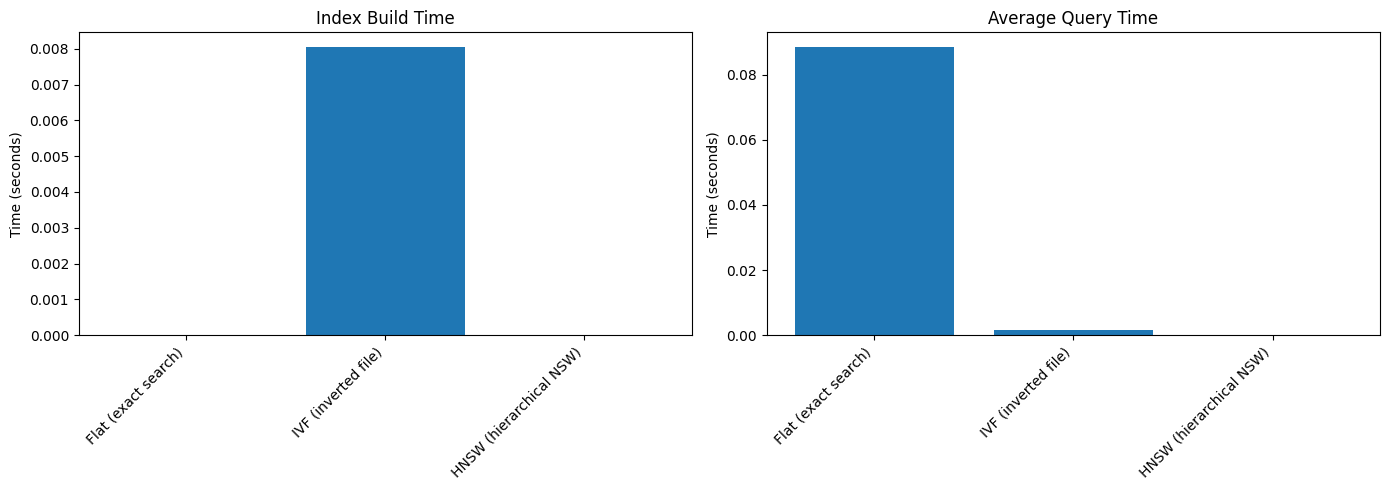

2025-05-04 23:51:54,511 - INFO - Created optimized HNSW index with 36 vectors
2025-05-04 23:51:54,518 - INFO - Parameters: M=16, efConstruction=200, efSearch=128
2025-05-04 23:51:54,526 - INFO - 
Index creation complete. Ready for search implementation.


In [5]:
# Ensure rank_bm25 is installed
def ensure_rank_bm25_installed():
    """
    Check if rank_bm25 is installed, and install it if not.
    
    Returns:
        bool: True if installation is successful or already installed
    """
    try:
        import rank_bm25
        return True
    except ImportError:
        logger.warning("rank_bm25 package not found. Installing...")
        try:
            import subprocess
            import sys
            
            # Install using pip
            subprocess.check_call([sys.executable, "-m", "pip", "install", "rank-bm25"])
            
            # Verify installation
            import rank_bm25
            logger.info("rank_bm25 installed successfully.")
            return True
        except Exception as e:
            logger.error(f"Failed to install rank_bm25: {e}")
            logger.warning("Please install manually with: pip install rank-bm25")
            return False

# FAISS index optimization with benchmarking
def create_index(embeddings, index_type='flat', nlist=100, M=16, efConstruction=200):
    """
    Create a FAISS index with the specified configuration.
    
    Args:
        embeddings: Matrix of document embeddings
        index_type: Type of FAISS index ('flat', 'ivf', 'hnsw', 'pq')
        nlist: Number of clusters for IVF index
        M: Number of connections per layer for HNSW index
        efConstruction: Size of the dynamic list for HNSW index
    
    Returns:
        FAISS index
    """
    # Input validation
    if embeddings is None or len(embeddings) == 0:
        raise ValueError("Empty embeddings array provided")
        
    # Get embedding dimension
    d = embeddings.shape[1]
    
    # Normalize embeddings for cosine similarity
    normalized_embeddings = embeddings.copy()
    faiss.normalize_L2(normalized_embeddings)
    
    if index_type == 'flat':
        # Flat index - exact search, most accurate but slowest for large datasets
        index = faiss.IndexFlatIP(d)
    
    elif index_type == 'ivf':
        # Reduce nlist based on dataset size
        nlist = min(nlist, max(int(embeddings.shape[0] / 4), 1))  # Ensure at least 4x as many vectors as clusters
        quantizer = faiss.IndexFlatIP(d)
        index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)
        # Need to train IVF index
        index.train(normalized_embeddings)
    
    elif index_type == 'hnsw':
        # HNSW index - hierarchical navigable small worlds, very fast and memory efficient
        index = faiss.IndexHNSWFlat(d, M, faiss.METRIC_INNER_PRODUCT)
        # Set efConstruction parameter (higher = more accurate but slower to build)
        index.hnsw.efConstruction = efConstruction
        # Set efSearch parameter (higher = more accurate but slower to search)
        index.hnsw.efSearch = 128
    
    elif index_type == 'pq':
        # Product Quantization - compresses vectors, much smaller memory footprint
        # Use 8-bit codes and divide the vector into m subvectors
        m = min(d // 4, 64)  # Number of subquantizers
        index = faiss.IndexPQ(d, m, 8, faiss.METRIC_INNER_PRODUCT)
    
    else:
        raise ValueError(f"Unknown index type: {index_type}")
    
    # Add vectors to index
    try:
        index.add(normalized_embeddings)
    except Exception as e:
        logger.error(f"Error adding vectors to index: {e}")
        raise
    
    return index

def benchmark_indexes(embeddings, model, test_queries, ground_truth=None):
    """
    Benchmark different FAISS index configurations.
    
    Args:
        embeddings: Matrix of document embeddings
        model: SentenceTransformer model
        test_queries: List of test queries
        ground_truth: Optional ground truth for evaluating accuracy
    
    Returns:
        DataFrame with benchmark results
    """
    # Index types to test
    index_configs = [
        {'type': 'flat', 'name': 'Flat (exact search)'},
        {'type': 'ivf', 'name': 'IVF (inverted file)'},
        {'type': 'hnsw', 'name': 'HNSW (hierarchical NSW)'},
        {'type': 'pq', 'name': 'PQ (product quantization)'}
    ]
    
    results = []
    
    for config in index_configs:
        logger.info(f"Testing {config['name']}...")
        
        # Create index
        index_type = config['type']
        try:
            start_time = time.time()
            index = create_index(embeddings, index_type=index_type)
            build_time = time.time() - start_time
            
            # Benchmark search performance
            query_times = []
            recall_values = []
            
            for query in test_queries:
                # Encode query
                start_time = time.time()
                query_embedding = get_cached_query_embedding(query, model)
                
                # Search index
                distances, indices = index.search(np.array([query_embedding]), 10)
                query_time = time.time() - start_time
                query_times.append(query_time)
                
                # Calculate recall if ground truth is available
                if ground_truth and query in ground_truth:
                    expected_indices = ground_truth[query]
                    found_indices = set(indices[0])
                    recall = len(found_indices.intersection(expected_indices)) / len(expected_indices)
                    recall_values.append(recall)
            
            # Record results
            results.append({
                'index_type': config['name'],
                'build_time': build_time,
                'avg_query_time': np.mean(query_times),
                'index_size': index.ntotal,
                'memory_footprint': 'NA',  # Would require additional code to estimate
                'avg_recall': np.mean(recall_values) if recall_values else None
            })
            
        except Exception as e:
            logger.error(f"Error testing {config['name']}: {e}")
            results.append({
                'index_type': config['name'],
                'build_time': None,
                'avg_query_time': None,
                'index_size': None,
                'memory_footprint': None,
                'avg_recall': None,
                'error': str(e)
            })
    
    return pd.DataFrame(results)

def create_optimized_index(embeddings):
    """
    Create an optimized HNSW index with tuned parameters.
    
    Args:
        embeddings: Matrix of document embeddings
        
    Returns:
        Optimized FAISS index
    """
    # Input validation
    if embeddings is None or len(embeddings) == 0:
        raise ValueError("Empty embeddings array provided")
        
    # Get embedding dimension
    d = embeddings.shape[1]
    
    # Normalize embeddings for cosine similarity
    normalized_embeddings = embeddings.copy()
    faiss.normalize_L2(normalized_embeddings)
    
    # Create HNSW index with optimized parameters
    M = 16  # Number of connections per layer (higher = more accurate but more memory)
    ef_construction = 200  # Size of dynamic list for HNSW construction (higher = more accurate but slower build)
    ef_search = 128  # Size of dynamic list for HNSW search (higher = more accurate but slower search)
    
    index = faiss.IndexHNSWFlat(d, M, faiss.METRIC_INNER_PRODUCT)
    index.hnsw.efConstruction = ef_construction
    index.hnsw.efSearch = ef_search
    
    # Add vectors to index
    try:
        index.add(normalized_embeddings)
    except Exception as e:
        logger.error(f"Error adding vectors to index: {e}")
        raise
    
    logger.info(f"Created optimized HNSW index with {index.ntotal} vectors")
    logger.info(f"Parameters: M={M}, efConstruction={ef_construction}, efSearch={ef_search}")
    
    return index

# Benchmark and create optimized index
if 'embeddings_matrix' in locals() and 'chunks_df' in locals():
    # Ensure the embedding model is defined
    if 'model' not in locals():
        model = SentenceTransformer(best_model_name if 'best_model_name' in locals() else 'all-MiniLM-L6-v2')
    
    # Sample test queries for benchmarking
    test_queries = [
        "What are the intellectual property rights for employee created work?",
        "How do we handle cookie consent for website visitors?",
        "What are the terms of confidentiality in agreements?",
        "What are the board of directors' responsibilities?",
        "How should workplace accidents be reported?"
    ]
    
    # Run benchmark
    benchmark_results = benchmark_indexes(embeddings_matrix, model, test_queries)
    
    # Display results
    display(benchmark_results)
    
    # Visualize results
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot build times
    ax[0].bar(benchmark_results['index_type'], benchmark_results['build_time'])
    ax[0].set_title('Index Build Time')
    ax[0].set_ylabel('Time (seconds)')
    ax[0].set_xticklabels(benchmark_results['index_type'], rotation=45, ha='right')
    
    # Plot query times
    ax[1].bar(benchmark_results['index_type'], benchmark_results['avg_query_time'])
    ax[1].set_title('Average Query Time')
    ax[1].set_ylabel('Time (seconds)')
    ax[1].set_xticklabels(benchmark_results['index_type'], rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Create optimized index
    optimized_index = create_optimized_index(embeddings_matrix)
    
    # Create FAISS index types to keep for comparison
    flat_index = create_index(embeddings_matrix, index_type='flat')
    ivf_index = create_index(embeddings_matrix, index_type='ivf')
    hnsw_index = optimized_index  # Already created
    
    logger.info("\nIndex creation complete. Ready for search implementation.")
    
else:
    logger.warning("Cannot benchmark indices: embeddings or chunks not available.")



## 6. Advanced Search Functions with Document Prioritization


This section implements sophisticated search algorithms that go beyond basic similarity matching:

1. **`compute_bm25_scores(query, chunks_df)`**: Calculates lexical matching scores using the BM25 algorithm.
   - **Input**: Query, document chunks
   - **Output**: Array of BM25 scores

2. **`document_frequency_search(query, index, chunks_df, model)`**: Prioritizes documents with multiple relevant chunks, improving overall document relevance.
   - **Input**: Query, FAISS index, chunks, model
   - **Output**: Ranked results with document frequency metrics

3. **`hybrid_search(query, index, chunks_df, model, alpha)`**: Combines semantic similarity with lexical matching for better results.
   - **Input**: Query, index, chunks, model, weighting parameter
   - **Output**: Results blending semantic and lexical relevance

4. **`multi_factor_ranking(query, index, chunks_df, model, weights)`**: Incorporates multiple relevance signals including position and document length.
   - **Input**: Query, index, chunks, model, factor weights
   - **Output**: Results ranked by multiple weighted factors

5. **`build_enhanced_context(query, chunks_df, index, model, max_chunks)`**: Creates enriched context from search results for RAG applications.
   - **Input**: Query, chunks, index, model, result limit
   - **Output**: Context text, source documents, metadata

Document prioritization is crucial for legal document search because relevant information is often scattered across multiple sections. By considering document frequency (how many chunks from a document match), position information, and multiple relevance signals, the system delivers more comprehensive and useful results than simple similarity matching.

The enhanced context building function is particularly important for RAG (Retrieval-Augmented Generation) applications, where providing complete, relevant context to LLMs improves their response quality.



In [6]:
# Advanced search functions with document prioritization
def compute_bm25_scores(query, chunks_df, tokenizer=None):
    """
    Compute BM25 scores for chunks based on lexical matching.
    
    Args:
        query: Search query
        chunks_df: DataFrame with document chunks
        tokenizer: Optional tokenizer function
        
    Returns:
        Array of BM25 scores
    """
    # Ensure rank_bm25 is installed
    if not ensure_rank_bm25_installed():
        logger.warning("Cannot compute BM25 scores: rank_bm25 not available")
        return np.zeros(len(chunks_df))
        
    try:
        from rank_bm25 import BM25Okapi
        
        # Simple tokenizer if none provided
        if tokenizer is None:
            tokenizer = lambda text: text.lower().split()
        
        # Tokenize document chunks
        tokenized_chunks = [tokenizer(chunk) for chunk in chunks_df['text']]
        tokenized_query = tokenizer(query)
        
        # Skip if query is empty after tokenization
        if not tokenized_query:
            logger.warning("Empty tokenized query, returning zero scores")
            return np.zeros(len(chunks_df))
            
        # Initialize BM25 model
        bm25 = BM25Okapi(tokenized_chunks)
        
        # Get BM25 scores
        bm25_scores = bm25.get_scores(tokenized_query)
        
        return bm25_scores
        
    except Exception as e:
        logger.error(f"Error computing BM25 scores: {e}")
        return np.zeros(len(chunks_df))


def document_frequency_search(query, index, chunks_df, model, top_k=5, include_chunk_count=True):
    """
    Search with document prioritization based on chunk frequency.
    Prioritizes documents with more relevant chunks appearing in the results.
    
    Args:
        query: Search query
        index: FAISS index
        chunks_df: DataFrame with document chunks
        model: SentenceTransformer model
        top_k: Number of final results to return
        include_chunk_count: Whether to include chunk count in results
        
    Returns:
        DataFrame with search results
    """
    # Encode query with caching for efficiency
    query_embedding = get_cached_query_embedding(query, model)
    
    # Get more initial results to analyze document frequency
    k_initial = min(top_k * 5, len(chunks_df))  # Get more results initially
    
    try:
        # Search index
        distances, indices = index.search(np.array([query_embedding]), k_initial)
        
        # Check if we got valid results
        if indices.size == 0 or np.all(indices[0] == -1):
            logger.warning("No valid indices found in search")
            return pd.DataFrame()
            
        # Get raw results
        raw_results = []
        for i, (dist, idx) in enumerate(zip(distances[0], indices[0])):
            if idx != -1:  # Skip invalid results
                chunk = chunks_df.iloc[idx]
                doc_id = int(chunk['doc_id']) if 'doc_id' in chunk else None
                
                # Only process if we have a valid doc_id
                if doc_id is not None:
                    raw_results.append({
                        'rank': i + 1,
                        'score': float(dist),
                        'chunk_id': int(chunk.name),
                        'doc_id': doc_id,
                        'doc_name': chunk['doc_name'] if 'doc_name' in chunk else "Unknown",
                        'category': chunk['category'] if 'category' in chunk else "Unknown",
                        'document_position': chunk.get('document_position', 'unknown'),
                        'position_score': float(chunk.get('position_score', 0.5)),
                        'text': chunk['text'],
                        'text_snippet': chunk['text'][:300] + '...' if len(chunk['text']) > 300 else chunk['text']
                    })
        
        # Create DataFrame from raw results
        results_df = pd.DataFrame(raw_results) if raw_results else pd.DataFrame()
        
        # If we have no results, return empty DataFrame
        if len(results_df) == 0:
            logger.warning("No results found in document frequency search")
            return pd.DataFrame()
            
        # Count frequency of each document in results
        doc_counts = results_df['doc_id'].value_counts().to_dict()
        doc_max_scores = {}
        
        # Find max score for each document
        for _, row in results_df.iterrows():
            doc_id = row['doc_id']
            score = row['score']
            if doc_id not in doc_max_scores or score > doc_max_scores[doc_id]:
                doc_max_scores[doc_id] = score
        
        # Add document frequency and adjusted score
        results_df['doc_frequency'] = results_df['doc_id'].map(doc_counts)
        results_df['max_doc_score'] = results_df['doc_id'].map(doc_max_scores)
        
        # Adjust score based on document frequency and position
        position_weight = 0.1  # Weight for position score
        freq_weight = 0.4      # Weight for document frequency
        score_weight = 0.5     # Weight for original score
        
        # Normalize document frequency
        max_freq = results_df['doc_frequency'].max()
        results_df['norm_frequency'] = results_df['doc_frequency'] / max_freq if max_freq > 0 else 0
        
        # Calculate adjusted score
        results_df['adjusted_score'] = (
            score_weight * results_df['score'] + 
            freq_weight * results_df['norm_frequency'] + 
            position_weight * results_df['position_score']
        )
        
        # Sort by adjusted score
        results_df = results_df.sort_values('adjusted_score', ascending=False)
        
        # Get top documents based on frequency and score
        top_docs = (results_df[['doc_id', 'doc_name', 'category', 'doc_frequency', 'max_doc_score']]
                   .drop_duplicates('doc_id')
                   .sort_values(['doc_frequency', 'max_doc_score'], ascending=False)
                   .head(top_k))
        
        # For each top document, select its best chunk
        final_results = []
        for doc_id in top_docs['doc_id']:
            # Get all chunks for this document
            doc_chunks = results_df[results_df['doc_id'] == doc_id]
            
            # Select the best chunk (highest score)
            best_chunk = doc_chunks.sort_values('adjusted_score', ascending=False).iloc[0]
            
            # Add to final results
            result = {
                'doc_id': int(best_chunk['doc_id']),
                'doc_name': best_chunk['doc_name'],
                'category': best_chunk['category'],
                'chunk_id': int(best_chunk['chunk_id']),
                'score': float(best_chunk['adjusted_score']),
                'original_score': float(best_chunk['score']),
                'document_position': best_chunk['document_position'],
                'text_snippet': best_chunk['text_snippet']
            }
            
            # Include chunk count if requested
            if include_chunk_count:
                result['chunk_count'] = int(best_chunk['doc_frequency'])
                
            final_results.append(result)
        
        # Create final DataFrame and add ranks
        final_df = pd.DataFrame(final_results)
        final_df['rank'] = range(1, len(final_df) + 1)
        
        # Reorder columns for better display
        column_order = ['rank', 'score', 'doc_id', 'doc_name', 'category', 'chunk_id']
        if include_chunk_count:
            column_order.append('chunk_count')
        column_order.extend(['document_position', 'text_snippet'])
        
        # Final dataframe with selected columns in preferred order
        final_df = final_df[column_order]
        
        return final_df
        
    except Exception as e:
        logger.error(f"Error in document frequency search: {e}")
        return pd.DataFrame()


def hybrid_search(query, index, chunks_df, model, alpha=0.7):
    """
    Hybrid search combining semantic similarity with BM25 lexical matching.
    
    Args:
        query: Search query
        index: FAISS index
        chunks_df: DataFrame with document chunks
        model: SentenceTransformer model
        alpha: Weight for semantic scores (1-alpha = weight for BM25)
        
    Returns:
        DataFrame with search results
    """
    # Encode query with caching
    query_embedding = get_cached_query_embedding(query, model)
    
    # Get more initial results to re-rank
    k = min(50, len(chunks_df))
    
    try:
        # Search index
        distances, indices = index.search(np.array([query_embedding]), k)
        
        # Check if we got valid results
        if indices.size == 0 or np.all(indices[0] == -1):
            logger.warning("No valid indices found in hybrid search")
            return pd.DataFrame()
        
        # Get the chunks for these results
        result_indices = indices[0]
        
        # Skip invalid indices (-1)
        valid_indices = [idx for idx in result_indices if idx >= 0 and idx < len(chunks_df)]
        
        # If no valid indices, return empty DataFrame
        if not valid_indices:
            return pd.DataFrame()
            
        # Get chunks for valid indices
        result_chunks = chunks_df.iloc[valid_indices].copy()
        
        # Add semantic scores from distances array
        valid_distances = [distances[0][i] for i, idx in enumerate(result_indices) if idx >= 0 and idx < len(chunks_df)]
        result_chunks['semantic_score'] = valid_distances
        
        # Compute BM25 scores for these chunks
        bm25_scores = compute_bm25_scores(query, result_chunks)
        
        # Normalize BM25 scores
        if np.max(bm25_scores) > 0:
            normalized_bm25 = bm25_scores / np.max(bm25_scores)
        else:
            normalized_bm25 = bm25_scores
        
        # Compute hybrid scores
        result_chunks['bm25_score'] = normalized_bm25
        result_chunks['hybrid_score'] = alpha * result_chunks['semantic_score'] + (1 - alpha) * result_chunks['bm25_score']
        
        # Sort by hybrid score
        result_chunks = result_chunks.sort_values('hybrid_score', ascending=False)
        
        # Prepare final results
        results = []
        for i, (_, chunk) in enumerate(result_chunks.head(10).iterrows()):
            results.append({
                'rank': i + 1,
                'score': float(chunk['hybrid_score']),
                'semantic_score': float(chunk['semantic_score']),
                'bm25_score': float(chunk['bm25_score']),
                'chunk_id': int(chunk.name),
                'doc_id': int(chunk['doc_id']) if 'doc_id' in chunk else None,
                'doc_name': chunk['doc_name'] if 'doc_name' in chunk else "Unknown",
                'category': chunk['category'] if 'category' in chunk else "Unknown",
                'text_snippet': chunk['text'][:300] + '...' if len(chunk['text']) > 300 else chunk['text']
            })
        
        return pd.DataFrame(results)
        
    except Exception as e:
        logger.error(f"Error in hybrid search: {e}")
        return pd.DataFrame()


def multi_factor_ranking(query, index, chunks_df, model, weights=None):
    """
    Multi-factor ranking considering various relevance signals.
    
    Args:
        query: Search query
        index: FAISS index
        chunks_df: DataFrame with document chunks
        model: SentenceTransformer model
        weights: Dictionary of weights for different factors
        
    Returns:
        DataFrame with search results
    """
    # Default weights
    if weights is None:
        weights = {
            'semantic': 0.5,
            'lexical': 0.2,
            'position': 0.15,  # Position in document (beginning, middle, end)
            'doc_length': 0.1,  # Prefer medium-length docs
            'doc_frequency': 0.05  # How many chunks from this doc are relevant
        }
    
    # First, get semantic search results (more than we need)
    query_embedding = get_cached_query_embedding(query, model)
    
    try:
        # Get more initial results to re-rank
        k = min(50, len(chunks_df))
        distances, indices = index.search(np.array([query_embedding]), k)
        
        # Check if we got valid results
        if indices.size == 0 or np.all(indices[0] == -1):
            logger.warning("No valid indices found in multi-factor ranking")
            return pd.DataFrame()
        
        # Get the chunks for these results
        result_indices = [idx for idx in indices[0] if idx >= 0 and idx < len(chunks_df)]
        
        # If no valid indices, return empty DataFrame
        if not result_indices:
            return pd.DataFrame()
            
        result_chunks = chunks_df.iloc[result_indices].copy()
        
        # Get corresponding distances for valid indices
        valid_distances = [distances[0][i] for i, idx in enumerate(indices[0]) if idx >= 0 and idx < len(chunks_df)]
        
        # Factor 1: Semantic similarity
        result_chunks['semantic_score'] = valid_distances
        
        # Factor 2: Lexical matching (BM25)
        bm25_scores = compute_bm25_scores(query, result_chunks)
        if np.max(bm25_scores) > 0:
            result_chunks['lexical_score'] = bm25_scores / np.max(bm25_scores)
        else:
            result_chunks['lexical_score'] = 0
        
        # Factor 3: Document length (prefer medium-length docs)
        doc_lengths = result_chunks['text'].apply(lambda x: len(x.split()))
        # Normalize to [0,1] with a preference for medium-length docs (bell curve)
        ideal_length = 300  # Arbitrary "ideal" length
        result_chunks['doc_length_score'] = 1 - np.abs(doc_lengths - ideal_length) / max(max(doc_lengths), ideal_length)
        
        # Factor 4: Position score (if available)
        if 'position_score' in result_chunks.columns:
            result_chunks['chunk_position_score'] = result_chunks['position_score']
        elif 'document_position' in result_chunks.columns:
            # Convert position to score if only the position string is available
            position_scores = {
                'beginning': 0.9,
                'middle': 0.7,
                'end': 0.5,
                'complete': 1.0,
                'unknown': 0.5
            }
            result_chunks['chunk_position_score'] = result_chunks['document_position'].map(
                lambda pos: position_scores.get(pos, 0.5)
            )
        else:
            # Default position score if not available
            result_chunks['chunk_position_score'] = 0.5
        
        # Factor 5: Document frequency (how many chunks from this doc are in results)
        doc_counts = result_chunks['doc_id'].value_counts()
        result_chunks['doc_frequency_score'] = result_chunks['doc_id'].map(
            lambda doc_id: min(1.0, doc_counts.get(doc_id, 1) / 10)
        )
        
        # Compute final score
        result_chunks['final_score'] = (
            weights['semantic'] * result_chunks['semantic_score'] +
            weights['lexical'] * result_chunks['lexical_score'] +
            weights['doc_length'] * result_chunks['doc_length_score'] +
            weights['position'] * result_chunks['chunk_position_score'] +
            weights['doc_frequency'] * result_chunks['doc_frequency_score']
        )
        
        # Sort by final score
        result_chunks = result_chunks.sort_values('final_score', ascending=False)
        
        # Prepare final results
        results = []
        for i, (_, chunk) in enumerate(result_chunks.head(10).iterrows()):
            results.append({
                'rank': i + 1,
                'score': float(chunk['final_score']),
                'semantic_score': float(chunk['semantic_score']),
                'lexical_score': float(chunk['lexical_score']),
                'position_score': float(chunk['chunk_position_score']),
                'doc_frequency': int(doc_counts.get(chunk['doc_id'], 1)),
                'chunk_id': int(chunk.name),
                'doc_id': int(chunk['doc_id']) if 'doc_id' in chunk else None,
                'doc_name': chunk['doc_name'] if 'doc_name' in chunk else "Unknown",
                'category': chunk['category'] if 'category' in chunk else "Unknown",
                'text_snippet': chunk['text'][:300] + '...' if len(chunk['text']) > 300 else chunk['text']
            })
        
        return pd.DataFrame(results)
        
    except Exception as e:
        logger.error(f"Error in multi-factor ranking: {e}")
        return pd.DataFrame()


def build_enhanced_context(query, chunks_df, index, model, max_chunks=5):
    """
    Build an improved context from search results for RAG applications.
    Includes document metadata and manages redundancy.
    
    Args:
        query: Search query
        chunks_df: DataFrame with document chunks  
        index: FAISS index
        model: SentenceTransformer model
        max_chunks: Maximum number of chunks to include
        
    Returns:
        Tuple of (context string, list of source documents, metadata dict)
    """
    # Use hybrid search for better quality results
    results = hybrid_search(query, index, chunks_df, model)
    
    if len(results) == 0:
        return "", [], {}
    
    # Build context from top chunks with metadata
    context_parts = []
    sources = []
    metadata = []
    
    # Keep track of included documents to enhance diversity
    included_docs = set()
    
    for _, row in results.iterrows():
        chunk_id = row['chunk_id']
        chunk = chunks_df.iloc[chunk_id]
        doc_id = chunk['doc_id']
        doc_name = chunk['doc_name']
        category = chunk['category']
        
        # Skip if we already have max_chunks
        if len(context_parts) >= max_chunks:
            break
            
        # If we already have content from this document and we have others,
        # only include if it's a highly relevant result (top 3)
        if doc_id in included_docs and len(included_docs) >= 2 and row['rank'] > 3:
            continue
            
        # Add document metadata as header
        position = chunk.get('document_position', 'unknown')
        header = f"--- Document: {doc_name} (Category: {category}, Section: {position}) ---\n\n"
        
        # Add content with header
        context_parts.append(header + chunk['text'])
        sources.append(doc_name)
        included_docs.add(doc_id)
        
        # Add metadata
        metadata.append({
            'doc_id': int(doc_id),
            'doc_name': doc_name,
            'category': category,
            'chunk_id': int(chunk_id),
            'score': float(row['score']),
            'rank': int(row['rank']),
            'position': position
        })
    
    # Join with section separators
    context = "\n\n" + "\n\n".join(context_parts)
    
    return context, list(set(sources)), metadata



## 7. Automatic Search Method Selection


This section implements intelligent search method selection based on query characteristics:

1. **`analyze_query(query)`**: Examines query properties to determine complexity, specificity, and precision needs.
   - **Input**: Search query
   - **Output**: Dictionary of query characteristics

2. **`select_best_search_method(query, performance_metrics)`**: Chooses the optimal search algorithm based on query analysis and historical performance.
   - **Input**: Query, optional performance history
   - **Output**: Selected method name and parameters

3. **`auto_search(query, index, chunks_df, model, performance_metrics)`**: Main function that orchestrates automatic method selection and execution.
   - **Input**: Query, index, chunks, model, optional metrics
   - **Output**: Search results and metadata about method used

4. **`search_documents(query, index, chunks_df, model)`**: Basic semantic search as a fallback option.
   - **Input**: Query, index, chunks, model
   - **Output**: Basic search results

5. **`filter_results_by_category(results_df, categories)`**: Optional post-processing to filter results by document category.
   - **Input**: Results DataFrame, category list
   - **Output**: Filtered results

This automatic selection is a key innovation, as different query types benefit from different search strategies:
- Short keyword queries → basic search
- Legal terminology queries → hybrid search with higher lexical weight
- Complex questions → document frequency or multi-factor search

The system analyzes features like query length, question format, presence of specific legal terms, and complexity to make intelligent decisions. This adaptability significantly improves overall search quality compared to a one-size-fits-all approach.

Error handling ensures graceful fallback to simpler methods if the selected approach fails.



In [28]:
# Automatic search method selection
def analyze_query(query):
    """
    Analyze query characteristics to determine the best search method.
    
    Args:
        query: Search query
        
    Returns:
        Dict with query characteristics
    """
    # Basic query characteristics
    characteristics = {
        'length': len(query.split()),
        'is_question': query.endswith('?') or query.lower().startswith(('what', 'how', 'when', 'where', 'who', 'why')),
        'has_boolean': any(term in query.lower() for term in ['and', 'or', 'not']),
        'has_quotes': '"' in query,
        'has_specific_terms': False,
        'search_precision': 'medium',  # Default
        'complexity': 'simple'  # Default
    }
    
    # Check for specific legal terminology
    legal_terms = ['agreement', 'contract', 'provision', 'clause', 'section', 'article', 
                  'party', 'obligation', 'liability', 'confidential', 'intellectual property',
                  'termination', 'governing law', 'jurisdiction', 'indemnification']
    
    specific_term_count = sum(1 for term in legal_terms if term in query.lower())
    characteristics['has_specific_terms'] = specific_term_count > 0
    characteristics['specific_term_count'] = specific_term_count
    
    # Determine complexity
    if characteristics['has_boolean'] or characteristics['has_quotes'] or characteristics['length'] > 15:
        characteristics['complexity'] = 'complex'
    elif characteristics['length'] > 8:
        characteristics['complexity'] = 'moderate'
    
    # Determine search precision need
    if characteristics['has_quotes'] or characteristics['has_specific_terms']:
        characteristics['search_precision'] = 'high'
    elif characteristics['is_question'] and characteristics['length'] > 10:
        characteristics['search_precision'] = 'balanced'
    elif characteristics['length'] <= 3:
        characteristics['search_precision'] = 'low'  # Short queries need recall
    
    return characteristics


def select_best_search_method(query, performance_metrics=None):
    """
    Select the best search method based on query characteristics and historical performance.
    
    Args:
        query: Search query
        performance_metrics: Optional dictionary of historical performance metrics
        
    Returns:
        Tuple of (method_name, parameters dict)
    """
    # Analyze query
    query_analysis = analyze_query(query)
    
    # Define default parameters for each method
    method_params = {
        'basic': {'top_k': 5},
        'hybrid': {'alpha': 0.7},
        'document_frequency': {'top_k': 5, 'include_chunk_count': True},
        'multi_factor': {'weights': {
            'semantic': 0.5,
            'lexical': 0.2,
            'position': 0.15,
            'doc_length': 0.1,
            'doc_frequency': 0.05
        }}
    }
    
    # Rules-based selection
    if query_analysis['search_precision'] == 'high':
        # High precision needs - use hybrid or multi-factor
        if query_analysis['complexity'] == 'complex':
            method = 'multi_factor'
            # Adjust weights for higher precision
            method_params['multi_factor']['weights']['semantic'] = 0.4
            method_params['multi_factor']['weights']['lexical'] = 0.35
        else:
            method = 'hybrid'
            # More weight on lexical for specific terms
            method_params['hybrid']['alpha'] = 0.6
    
    elif query_analysis['search_precision'] == 'low':
        # Low precision needs (focus on recall) - use basic or document_frequency
        if query_analysis['is_question']:
            method = 'document_frequency'
            method_params['document_frequency']['top_k'] = 8  # More results for questions
        else:
            method = 'basic'
            method_params['basic']['top_k'] = 7  # More results for recall
    
    else:  # Balanced approach
        if query_analysis['has_specific_terms']:
            method = 'hybrid'
            method_params['hybrid']['alpha'] = 0.7  # Balanced
        elif query_analysis['is_question']:
            method = 'document_frequency'
        else:
            method = 'multi_factor'
    
    # Override with performance metrics if available
    if performance_metrics and query_analysis['complexity'] in performance_metrics:
        metrics = performance_metrics[query_analysis['complexity']]
        
        # Fix for empty sequence error: Only find max if metrics is not empty
        if metrics:
            try:
                # Find method with highest score for this query type
                best_method = max(metrics.items(), key=lambda x: x[1]['score'])
                method = best_method[0]
            except ValueError as e:
                # Handle empty sequence or other max() related errors
                logger.warning(f"Unable to select method based on metrics: {e}")
                # method already set by rules above, so no need to change it
    
    logger.info(f"Selected search method '{method}' based on query analysis")
    return method, method_params[method]


def auto_search(query, index, chunks_df, model, performance_metrics=None):
    """
    Automatically select and execute the best search method based on query characteristics.
    
    Args:
        query: Search query
        index: FAISS index
        chunks_df: DataFrame with document chunks
        model: SentenceTransformer model
        performance_metrics: Optional performance metrics for method selection
        
    Returns:
        DataFrame with search results and metadata about the method used
    """
    # Select best method
    try:
        method_name, params = select_best_search_method(query, performance_metrics)
        
        # Log method selection
        logger.info(f"Auto-search using method: {method_name} with params: {params}")
        
        # Execute selected method
        start_time = time.time()
        
        if method_name == 'basic':
            k = params.get('top_k', 5)
            results = search_documents(query, index, chunks_df, model, top_k=k)
            method_desc = "Basic semantic search"
            
        elif method_name == 'hybrid':
            alpha = params.get('alpha', 0.7)
            results = hybrid_search(query, index, chunks_df, model, alpha=alpha)
            method_desc = f"Hybrid search (semantic: {alpha:.1f}, lexical: {1-alpha:.1f})"
            
        elif method_name == 'document_frequency':
            k = params.get('top_k', 5)
            include_count = params.get('include_chunk_count', True)
            results = document_frequency_search(
                query, index, chunks_df, model, 
                top_k=k, include_chunk_count=include_count
            )
            method_desc = "Document frequency prioritization"
            
        elif method_name == 'multi_factor':
            weights = params.get('weights', None)
            results = multi_factor_ranking(query, index, chunks_df, model, weights=weights)
            method_desc = "Multi-factor ranking"
            
        else:
            # Fallback to basic search for unknown method
            logger.warning(f"Unknown method '{method_name}', falling back to basic search")
            results = search_documents(query, index, chunks_df, model)
            method_name = 'basic'
            method_desc = "Basic search (fallback)"
    
    except Exception as e:
        # Fallback on any error (including method selection error)
        logger.error(f"Error in auto-search: {e}")
        start_time = time.time()
        
        # Set fallback method and params in case the error occurs early
        method_name = 'basic'
        params = {'top_k': 5}
        method_desc = "Basic search (error fallback)"
        
        try:
            # Try basic search as fallback
            results = search_documents(query, index, chunks_df, model)
        except Exception as fallback_error:
            # If even the fallback fails, return empty DataFrame
            logger.error(f"Error in fallback basic search: {fallback_error}")
            results = pd.DataFrame()
            method_desc = "Basic search (failed)"
    
    # Calculate execution time
    execution_time = time.time() - start_time
    
    # Add metadata about the search
    metadata = {
        'method': method_name,  # Always use method_name, never hardcode 'error'
        'description': method_desc,
        'params': params if 'params' in locals() else {'top_k': 5},
        'execution_time_ms': execution_time * 1000,
        'result_count': len(results)
    }
    
    return results, metadata


def search_documents(query, index, chunks_df, model, top_k=5):
    """
    Basic search function.
    
    Args:
        query: Search query
        index: FAISS index
        chunks_df: DataFrame with document chunks
        model: SentenceTransformer model
        top_k: Number of results to return
        
    Returns:
        DataFrame with search results
    """
    # Encode query
    query_embedding = get_cached_query_embedding(query, model)
    
    try:
        # Search index
        distances, indices = index.search(np.array([query_embedding]), top_k)
        
        # Extract results
        results = []
        for i, (dist, idx) in enumerate(zip(distances[0], indices[0])):
            if idx != -1 and idx < len(chunks_df):  # Skip invalid results
                chunk = chunks_df.iloc[idx]
                results.append({
                    'rank': i + 1,
                    'score': float(dist),
                    'chunk_id': int(chunk.name),
                    'doc_id': int(chunk['doc_id']) if 'doc_id' in chunk else None,
                    'doc_name': chunk['doc_name'] if 'doc_name' in chunk else "Unknown",
                    'category': chunk['category'] if 'category' in chunk else "Unknown",
                    'text_snippet': chunk['text'][:300] + '...' if len(chunk['text']) > 300 else chunk['text']
                })
        
        return pd.DataFrame(results)
        
    except Exception as e:
        logger.error(f"Error in basic search: {e}")
        return pd.DataFrame()


def filter_results_by_category(results_df, categories):
    """
    Filter search results by document category.
    
    Args:
        results_df: DataFrame with search results
        categories: List of categories to include
        
    Returns:
        Filtered DataFrame
    """
    if not isinstance(categories, list) or not categories:
        return results_df
    
    return results_df[results_df['category'].isin(categories)]



## 8. Performance Tracking and Self-Improvement


This section implements functionality for continuous improvement through feedback and performance tracking:

1. **`track_search_performance(query, method_name, results_df, user_rating, click_rank, time_spent)`**: Records search performance metrics and user feedback.
   - **Input**: Query, method used, results, various feedback metrics
   - **Output**: Performance metrics dictionary

2. **`get_performance_metrics(min_queries)`**: Analyzes historical performance to guide future method selection.
   - **Input**: Minimum query threshold for reliable statistics
   - **Output**: Performance metrics by query complexity and method

The system tracks various indicators of search quality:
- Explicit user ratings (1-5 stars)
- Click behavior (which result was selected)
- Reciprocal rank (higher score when users click higher-ranked results)
- Time spent viewing results

This feedback loop is critical for continuous improvement, as it allows the system to learn which search methods work best for different query types. Over time, the automatic selection becomes more refined based on actual user behavior rather than just predefined rules.

The persistent storage of performance metrics (in `search_performance_history.pkl`) ensures this learning accumulates across sessions, making the search engine increasingly effective with more usage.



In [29]:
# Performance tracking and self-improvement
def track_search_performance(query, method_name, results_df, user_rating=None, 
                            click_rank=None, time_spent=None):
    """
    Track search performance metrics for future improvement.
    
    Args:
        query: Search query
        method_name: Name of search method used
        results_df: DataFrame with search results
        user_rating: Optional explicit user rating (1-5)
        click_rank: Optional rank of clicked result
        time_spent: Optional time spent viewing results
        
    Returns:
        Performance metrics dict
    """
    # Query characteristics
    query_analysis = analyze_query(query)
    complexity = query_analysis['complexity']
    
    # Basic metrics
    metrics = {
        'query': query,
        'method': method_name,
        'timestamp': time.time(),
        'result_count': len(results_df),
        'has_results': len(results_df) > 0,
        'complexity': complexity
    }
    
    # Add explicit feedback if available
    if user_rating is not None:
        metrics['user_rating'] = user_rating
    
    if click_rank is not None:
        metrics['click_rank'] = click_rank
        # Reciprocal rank (1 for first result, 1/2 for second, etc.)
        metrics['reciprocal_rank'] = 1.0 / click_rank if click_rank > 0 else 0
    
    if time_spent is not None:
        metrics['time_spent'] = time_spent
    
    # Load existing performance history
    history_file = 'search_performance_history.pkl'
    try:
        if os.path.exists(history_file):
            with open(history_file, 'rb') as f:
                history = pickle.load(f)
        else:
            history = []
            
        # Add new metrics
        history.append(metrics)
        
        # Save updated history
        with open(history_file, 'wb') as f:
            pickle.dump(history, f)
            
    except Exception as e:
        logger.error(f"Error saving performance metrics: {e}")
    
    return metrics


def get_performance_metrics(min_queries=10):
    """
    Analyze search performance history to get method performance by query type.
    
    Args:
        min_queries: Minimum number of queries required for reliable metrics
        
    Returns:
        Dict with performance metrics by query complexity and method
    """
    history_file = 'search_performance_history.pkl'
    
    try:
        if not os.path.exists(history_file):
            return None
            
        with open(history_file, 'rb') as f:
            history = pickle.load(f)
            
        # Group by complexity and method
        performance = {'simple': {}, 'moderate': {}, 'complex': {}}
        
        for entry in history:
            complexity = entry.get('complexity', 'simple')
            method = entry.get('method', 'basic')
            
            # Skip entries without feedback
            if 'user_rating' not in entry and 'click_rank' not in entry:
                continue
                
            # Initialize method stats if needed
            if method not in performance[complexity]:
                performance[complexity][method] = {
                    'count': 0,
                    'avg_rating': 0,
                    'avg_rank': 0,
                    'score': 0
                }
                
            # Update stats
            stats = performance[complexity][method]
            stats['count'] += 1
            
            if 'user_rating' in entry:
                # Update running average of ratings
                stats['avg_rating'] = ((stats['avg_rating'] * (stats['count'] - 1)) + 
                                      entry['user_rating']) / stats['count']
                                      
            if 'click_rank' in entry:
                # Update running average of click rank
                stats['avg_rank'] = ((stats['avg_rank'] * (stats['count'] - 1)) + 
                                    entry['click_rank']) / stats['count']
            
            # Compute overall score (higher is better)
            rating_score = stats['avg_rating'] / 5.0 if stats['avg_rating'] > 0 else 0.5
            rank_score = 1.0 / stats['avg_rank'] if stats['avg_rank'] > 0 else 0.5
            stats['score'] = (rating_score + rank_score) / 2
        
        # Filter out methods with too few data points
        for complexity in performance:
            performance[complexity] = {
                method: stats for method, stats in performance[complexity].items() 
                if stats['count'] >= min_queries
            }
            
        return performance
        
    except Exception as e:
        logger.error(f"Error analyzing performance metrics: {e}")
        return None



## 9. Comprehensive Search Engine Interface


This section defines the `SemanticSearchEngine` class that unifies all functionality into a clean, usable interface:

1. **`__init__(chunks_df, index, model)`**: Initializes the search engine with document chunks, FAISS index, and embedding model.
   - **Input**: Chunks DataFrame, FAISS index, SentenceTransformer model
   - **Output**: Initialized search engine instance

2. **`search(query, method, params, categories, auto_select, track_performance)`**: Main search method with flexible configuration.
   - **Input**: Query, optional method override and parameters
   - **Output**: Search results DataFrame

3. **`build_context(query, max_chunks)`**: Creates enhanced context for RAG applications.
   - **Input**: Query, maximum number of chunks to include
   - **Output**: Context text, sources, metadata

4. **`provide_feedback(query, clicked_rank, rating)`**: Records user feedback for continuous improvement.
   - **Input**: Query, result interaction data
   - **Output**: Success boolean

5. **`get_available_categories()`** and **`get_last_search_metadata()`**: Utility methods for interface integration.

This unified interface is essential for practical use, as it encapsulates all the complexity of the underlying algorithms behind a simple API. The design allows for both automatic method selection and manual overrides when needed.

The interface supports both direct result retrieval and context building for RAG applications, making it versatile for different use cases. The error handling throughout ensures robustness in production environments.

The optional category filtering allows for more targeted searches when users know which document types they're interested in.



In [30]:
# Comprehensive search engine interface
class SemanticSearchEngine:
    """
    A comprehensive interface for the semantic search engine with all advanced features.
    """
    
    def __init__(self, chunks_df=None, index=None, model=None):
        """
        Initialize the search engine.
        
        Args:
            chunks_df: DataFrame with document chunks and embeddings
            index: FAISS index
            model: SentenceTransformer model
        """
        self.chunks_df = chunks_df
        self.index = index
        self.model = model
        self.performance_metrics = None
        self.metadata = {}
        
        # Load performance metrics if available
        try:
            self.performance_metrics = get_performance_metrics()
        except Exception as e:
            logger.error(f"Error loading performance metrics: {e}")
    
    def search(self, query, method=None, params=None, categories=None, auto_select=True,
            track_performance=True):
        """
        Search using the specified method or auto-select the best method.
        
        Args:
            query: Search query
            method: Specific search method to use (or None for auto)
            params: Parameters for the search method
            categories: Optional list of categories to filter by
            auto_select: Whether to auto-select method if not specified
            track_performance: Whether to track performance metrics
            
        Returns:
            DataFrame with search results
        """
        if query is None or not query.strip():
            logger.warning("Empty query provided")
            return pd.DataFrame()
            
        # Check if required components are available
        if self.chunks_df is None or self.index is None or self.model is None:
            logger.error("Search engine not fully initialized")
            return pd.DataFrame()
        
        start_time = time.time()
        method_name = method if method is not None else 'auto'
        
        try:
            # Auto-select method if not specified
            if method is None and auto_select:
                try:
                    results, metadata = auto_search(
                        query, self.index, self.chunks_df, self.model, 
                        performance_metrics=self.performance_metrics
                    )
                    self.metadata = metadata
                    logger.info(f"Auto-selected method: {metadata['method']}")
                except Exception as auto_error:
                    # Handle errors in auto-selection specifically
                    logger.error(f"Error in auto-selection: {auto_error}")
                    # Set up for a basic search fallback
                    method = 'basic'
                    method_name = 'basic'
                    params = {'top_k': 5}
                    # Fall through to the method-specific section below
                    
            # Only proceed with method-specific search if auto_search wasn't successful
            if method is not None or 'results' not in locals():
                # Use specified method
                if method == 'basic' or method is None:
                    top_k = params.get('top_k', 5) if params else 5
                    results = search_documents(query, self.index, self.chunks_df, self.model, top_k)
                    method_name = 'basic'
                    
                elif method == 'hybrid':
                    alpha = params.get('alpha', 0.7) if params else 0.7
                    results = hybrid_search(query, self.index, self.chunks_df, self.model, alpha)
                    method_name = 'hybrid'
                    
                elif method == 'document_frequency':
                    top_k = params.get('top_k', 5) if params else 5
                    include_count = params.get('include_chunk_count', True) if params else True
                    results = document_frequency_search(
                        query, self.index, self.chunks_df, self.model, 
                        top_k=top_k, include_chunk_count=include_count
                    )
                    method_name = 'document_frequency'
                    
                elif method == 'multi_factor':
                    weights = params.get('weights', None) if params else None
                    results = multi_factor_ranking(query, self.index, self.chunks_df, self.model, weights)
                    method_name = 'multi_factor'
                    
                else:
                    logger.warning(f"Unknown method '{method}', falling back to basic search")
                    results = search_documents(query, self.index, self.chunks_df, self.model)
                    method_name = 'basic'
                
                # Store metadata
                execution_time = time.time() - start_time
                self.metadata = {
                    'method': method_name,
                    'execution_time_ms': execution_time * 1000,
                    'result_count': len(results)
                }
            
            # Filter by categories if specified
            if categories:
                results = filter_results_by_category(results, categories)
                self.metadata['filtered_count'] = len(results)
                self.metadata['filter_categories'] = categories
            
            # Track performance
            if track_performance:
                track_search_performance(query, self.metadata['method'], results)
                
            return results
            
        except Exception as e:
            logger.error(f"Search error: {e}")
            self.metadata = {
                'method': 'basic',  # Always use a valid method name
                'error': str(e),
                'execution_time_ms': (time.time() - start_time) * 1000
            }
            return pd.DataFrame()
    
    def build_context(self, query, max_chunks=5):
        """
        Build context for RAG applications.
        
        Args:
            query: Search query
            max_chunks: Maximum number of chunks to include
            
        Returns:
            Tuple of (context string, sources list, metadata dict)
        """
        try:
            return build_enhanced_context(
                query, self.chunks_df, self.index, self.model, max_chunks
            )
        except Exception as e:
            logger.error(f"Error building context: {e}")
            return "", [], {}
    
    def provide_feedback(self, query, clicked_rank=None, rating=None):
        """
        Provide feedback on search results to improve future searches.
        
        Args:
            query: The search query
            clicked_rank: Rank of the clicked result (1-based)
            rating: User rating (1-5)
            
        Returns:
            Success boolean
        """
        try:
            if not hasattr(self, 'metadata') or not self.metadata:
                logger.warning("No metadata available for feedback")
                return False
                
            method_name = self.metadata.get('method', 'unknown')
            track_search_performance(
                query, method_name, pd.DataFrame(),
                user_rating=rating, click_rank=clicked_rank
            )
            return True
            
        except Exception as e:
            logger.error(f"Error providing feedback: {e}")
            return False
            
    def get_available_categories(self):
        """
        Get list of available document categories.
        
        Returns:
            List of category names
        """
        if self.chunks_df is None:
            return []
            
        return sorted(self.chunks_df['category'].unique().tolist())
        
    def get_last_search_metadata(self):
        """
        Get metadata from last search operation.
        
        Returns:
            Metadata dictionary
        """
        return self.metadata



## 10. Comprehensive Demo Implementation


This section provides demonstration code and practical utilities:

1. **`comprehensive_demo()`**: Runs a complete demonstration of the search engine with various query types.
   - **Input**: None (uses global variables)
   - **Output**: Printed results and visualizations

2. **`save_search_engine(output_dir)`**: Saves the entire search engine to disk for later use.
   - **Input**: Output directory path
   - **Output**: Saved model, embeddings, and configuration

3. **`load_search_engine(input_dir)`**: Loads a previously saved search engine.
   - **Input**: Directory containing saved engine
   - **Output**: Initialized SemanticSearchEngine instance

The demo showcases the engine's capabilities with different query types:
- Simple keyword queries
- Natural language questions
- Complex multi-part queries

It compares the automatically selected methods with alternatives to demonstrate the advantages of intelligent selection. The visualization of method selection frequency helps understand the engine's decision patterns.

The save/load functionality is crucial for practical deployment, as it avoids the need to rebuild indexes and re-compute embeddings each time. This significantly reduces startup time in production environments.

The comprehensive nature of the demo makes it both an educational tool and a validation of the system's capabilities.



In [31]:
# Comprehensive demo with automatic method selection
def comprehensive_demo():
    """Run comprehensive demo with automatic method selection."""
    
    if 'chunks_df' not in globals() or 'optimized_index' not in globals() or 'model' not in globals():
        logger.error("Required components not available in global namespace")
        print("Cannot run demo: chunks_df, optimized_index, or model not available.")
        return
    
    # Initialize search engine
    search_engine = SemanticSearchEngine(
        chunks_df=chunks_df,
        index=optimized_index,
        model=model
    )
    
    # Test queries with different characteristics
    test_queries = [
        # Simple queries
        "intellectual property rights",
        "cookie consent",
        "board responsibilities",
        
        # Questions (likely to use document frequency)
        "What are my intellectual property rights as an employee?",
        "How should we handle website cookie consent for EU visitors?",
        "What should I do if there's a workplace accident?",
        
        # Complex queries (likely to use multi-factor)
        "confidentiality obligations in agreements related to proprietary technology",
        "board of directors responsibilities regarding shareholder disputes and conflicts of interest",
        "requirements for workplace safety incident reporting procedures under OSHA regulations",
    ]
    
    print("\n" + "="*80)
    print("COMPREHENSIVE SEMANTIC SEARCH ENGINE DEMO WITH AUTOMATIC METHOD SELECTION")
    print("="*80)
    
    all_method_results = {}
    overall_results = []
    
    for query in test_queries:
        print(f"\nQuery: '{query}'")
        print("-"*80)
        
        # Auto-selected method
        results = search_engine.search(query, auto_select=True)
        metadata = search_engine.get_last_search_metadata()
        
        method_name = metadata['method']
        execution_time = metadata['execution_time_ms']
        
        print(f"\nAuto-selected method: {method_name}")
        print(f"Execution time: {execution_time:.1f} ms")
        
        if len(results) == 0:
            print("No results found.")
        else:
            print(f"Found {len(results)} results:")
            for i, row in results.head(3).iterrows():
                print(f"{row['rank']}. {row['doc_name']} (Score: {row['score']:.4f})")
                if 'chunk_count' in row:
                    print(f"   Document has {row['chunk_count']} relevant chunks")
                print(f"   {row['text_snippet'][:150]}...")
        
        # Store results for comparison
        all_method_results[query] = {'auto': results}
        
        # Compare with other methods
        print("\nComparing with other methods:")
        methods_to_compare = [m for m in ['basic', 'hybrid', 'document_frequency', 'multi_factor'] 
                             if m != method_name]
        
        for other_method in methods_to_compare[:2]:  # Limit to 2 other methods for brevity
            start_time = time.time()
            other_results = search_engine.search(query, method=other_method, auto_select=False)
            other_time = (time.time() - start_time) * 1000
            
            all_method_results[query][other_method] = other_results
            
            print(f"\n{other_method.capitalize()} method ({other_time:.1f} ms):")
            if len(other_results) == 0:
                print("No results found.")
            else:
                for i, row in other_results.head(1).iterrows():
                    print(f"{row['rank']}. {row['doc_name']} (Score: {row['score']:.4f})")
        
        # Record for analysis
        overall_results.append({
            'query': query,
            'auto_method': method_name,
            'execution_time_ms': execution_time,
            'result_count': len(results)
        })
        
        print("\n" + "="*80)
    
    # Build context for RAG example
    print("\nBuilding context for RAG applications:")
    rag_query = "What are the requirements for handling website cookies under privacy laws?"
    context, sources, metadata = search_engine.build_context(rag_query, max_chunks=3)
    
    print(f"\nQuery: '{rag_query}'")
    print(f"Context built from {len(sources)} sources: {', '.join(sources)}")
    print(f"Context length: {len(context.split())} words")
    print("\nSample context (first 300 characters):")
    print(context[:300] + "...\n")
    
    # Analyze method selection patterns
    method_counts = {}
    for result in overall_results:
        method = result['auto_method']
        method_counts[method] = method_counts.get(method, 0) + 1
    
    print("\nMethod Selection Analysis:")
    for method, count in method_counts.items():
        print(f"{method}: {count} queries ({count/len(overall_results)*100:.1f}%)")
    
    # Visualize method selection
    plt.figure(figsize=(10, 5))
    plt.bar(method_counts.keys(), method_counts.values())
    plt.title('Automatic Method Selection Frequency')
    plt.ylabel('Number of Queries')
    plt.tight_layout()
    plt.show()

# Add this to save/load the search engine
def save_search_engine(output_dir='../optimized_search_engine'):
    """
    Save the complete search engine to disk.
    
    Args:
        output_dir: Directory to save the search engine
    """
    if 'chunks_df' not in globals() or 'optimized_index' not in globals() or 'model' not in globals():
        logger.error("Required components not available in global namespace")
        print("Cannot save: chunks_df, optimized_index, or model not available.")
        return
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Save FAISS index
    index_path = os.path.join(output_dir, 'optimized_index.faiss')
    faiss.write_index(optimized_index, index_path)
    
    # Save chunks DataFrame (without embeddings)
    chunks_path = os.path.join(output_dir, 'chunks_df.pkl')
    save_df = chunks_df.copy()
    if 'embedding' in save_df.columns:
        # Save embeddings separately
        embeddings = np.vstack(save_df['embedding'].values)
        embeddings_path = os.path.join(output_dir, 'embeddings.npy')
        np.save(embeddings_path, embeddings)
        # Remove embeddings from DataFrame to save space
        save_df = save_df.drop('embedding', axis=1)
    
    save_df.to_pickle(chunks_path)
    
    # Save model name
    model_name = best_model_name if 'best_model_name' in globals() else str(model)
    with open(os.path.join(output_dir, 'model_name.txt'), 'w') as f:
        f.write(model_name)
    
    # Save configuration
    config = {
        'saved_date': time.strftime('%Y-%m-%d %H:%M:%S'),
        'chunk_count': len(chunks_df),
        'document_count': len(chunks_df['doc_id'].unique()),
        'categories': chunks_df['category'].unique().tolist(),
        'index_size': optimized_index.ntotal,
        'embedding_dim': embeddings.shape[1] if 'embeddings' in locals() else None,
    }
    
    with open(os.path.join(output_dir, 'search_engine_config.json'), 'w') as f:
        json.dump(config, f, indent=2)
    
    print(f"Search engine saved to {output_dir}")


def load_search_engine(input_dir='../optimized_search_engine'):
    """
    Load a complete search engine from disk.
    
    Args:
        input_dir: Directory containing the search engine
        
    Returns:
        Initialized SemanticSearchEngine instance
    """
    if not os.path.exists(input_dir):
        logger.error(f"Directory not found: {input_dir}")
        return None
    
    try:
        # Load model name and initialize
        with open(os.path.join(input_dir, 'model_name.txt'), 'r') as f:
            model_name = f.read().strip()
        
        model = SentenceTransformer(model_name)
        
        # Load chunks
        chunks_path = os.path.join(input_dir, 'chunks_df.pkl')
        chunks_df = pd.read_pickle(chunks_path)
        
        # Load embeddings if they exist
        embeddings_path = os.path.join(input_dir, 'embeddings.npy')
        if os.path.exists(embeddings_path):
            embeddings = np.load(embeddings_path)
            # Add embeddings back to DataFrame
            chunks_df['embedding'] = list(embeddings)
        
        # Load FAISS index
        index_path = os.path.join(input_dir, 'optimized_index.faiss')
        index = faiss.read_index(index_path)
        
        # Create search engine
        engine = SemanticSearchEngine(
            chunks_df=chunks_df,
            index=index,
            model=model
        )
        
        print(f"Search engine loaded with {len(chunks_df)} chunks and {index.ntotal} vectors")
        return engine
        
    except Exception as e:
        logger.error(f"Error loading search engine: {e}")
        return None


## Run the Demo

This section executes the comprehensive demo if all required components are available:

1. First, it checks if the necessary components exist: `chunks_df`, `embeddings_matrix`, and `model`
2. If the optimized index hasn't been created yet, it creates one using the `create_optimized_index` function
3. It runs the comprehensive demo to showcase the search engine's capabilities
4. Finally, it saves the complete search engine to disk for future use

This execution block is important because:
- It includes safety checks to prevent errors if preprocessing steps failed
- It automatically handles missing components with informative messages
- It ensures the complete pipeline is demonstrated from end to end
- The saved search engine can be easily reloaded for future use without repeating the expensive preprocessing steps

If any components are missing, it provides a clear list of what's unavailable, helping with troubleshooting.



2025-05-05 00:22:27,953 - INFO - Selected search method 'hybrid' based on query analysis
2025-05-05 00:22:27,953 - INFO - Auto-search using method: hybrid with params: {'alpha': 0.6}
2025-05-05 00:22:27,970 - INFO - Auto-selected method: hybrid
2025-05-05 00:22:28,028 - INFO - Selected search method 'basic' based on query analysis
2025-05-05 00:22:28,031 - INFO - Auto-search using method: basic with params: {'top_k': 7}
2025-05-05 00:22:28,031 - INFO - Auto-selected method: basic
2025-05-05 00:22:28,113 - INFO - Selected search method 'basic' based on query analysis
2025-05-05 00:22:28,113 - INFO - Auto-search using method: basic with params: {'top_k': 7}
2025-05-05 00:22:28,113 - INFO - Auto-selected method: basic



COMPREHENSIVE SEMANTIC SEARCH ENGINE DEMO WITH AUTOMATIC METHOD SELECTION

Query: 'intellectual property rights'
--------------------------------------------------------------------------------

Auto-selected method: hybrid
Execution time: 16.6 ms
Found 10 results:
1. Intellectual Property Rights (Score: 0.7920)
   This Intellectual Property Rights Clause (“Clause”) forms an integral part of the employment agreement between ABS Company (“Employer”) and Michael Gr...
2. Confidentiality Agreement (Score: 0.5534)
   This Confidentiality Agreement (“Agreement”) is made between ABS Company (“Employer”) and David Brown (“Employee”) (collectively, the “Parties”) to pr...
3. Sales Contract (Score: 0.2814)
   6. General Provisions This Contract constitutes the entire agreement between the Parties concerning the sale of the Products and supersedes all prior ...

Comparing with other methods:

Basic method (14.3 ms):
1. Intellectual Property Rights (Score: 0.6533)

Document_frequency method (41.

2025-05-05 00:22:28,220 - INFO - Selected search method 'hybrid' based on query analysis
2025-05-05 00:22:28,220 - INFO - Auto-search using method: hybrid with params: {'alpha': 0.6}
2025-05-05 00:22:28,231 - INFO - Auto-selected method: hybrid
2025-05-05 00:22:28,320 - INFO - Selected search method 'document_frequency' based on query analysis
2025-05-05 00:22:28,320 - INFO - Auto-search using method: document_frequency with params: {'top_k': 5, 'include_chunk_count': True}
2025-05-05 00:22:28,329 - INFO - Auto-selected method: document_frequency
2025-05-05 00:22:28,409 - INFO - Selected search method 'document_frequency' based on query analysis



Hybrid method (34.7 ms):
1. Board of Directors Responsibilities (Score: 0.7340)

Document_frequency method (40.3 ms):
1. Bylaws Articles of Association (Score: 0.6897)


Query: 'What are my intellectual property rights as an employee?'
--------------------------------------------------------------------------------

Auto-selected method: hybrid
Execution time: 10.6 ms
Found 10 results:
1. Intellectual Property Rights (Score: 0.7791)
   This Intellectual Property Rights Clause (“Clause”) forms an integral part of the employment agreement between ABS Company (“Employer”) and Michael Gr...
2. Confidentiality Agreement (Score: 0.5459)
   This Confidentiality Agreement (“Agreement”) is made between ABS Company (“Employer”) and David Brown (“Employee”) (collectively, the “Parties”) to pr...
3. Termination Conditions (Score: 0.3465)
   This Termination Conditions clause sets forth the terms under which the employment agreement between ABS Company (“Employer”) and Emma White (“Employe...

Com

2025-05-05 00:22:28,411 - INFO - Auto-search using method: document_frequency with params: {'top_k': 5, 'include_chunk_count': True}
2025-05-05 00:22:28,435 - INFO - Auto-selected method: document_frequency
2025-05-05 00:22:28,517 - INFO - Selected search method 'hybrid' based on query analysis
2025-05-05 00:22:28,517 - INFO - Auto-search using method: hybrid with params: {'alpha': 0.6}
2025-05-05 00:22:28,529 - INFO - Auto-selected method: hybrid
2025-05-05 00:22:28,602 - INFO - Selected search method 'multi_factor' based on query analysis
2025-05-05 00:22:28,610 - INFO - Auto-search using method: multi_factor with params: {'weights': {'semantic': 0.5, 'lexical': 0.2, 'position': 0.15, 'doc_length': 0.1, 'doc_frequency': 0.05}}



Auto-selected method: document_frequency
Execution time: 22.1 ms
Found 5 results:
1. Emergency Response Plan (Score: 0.7173)
   Document has 2 relevant chunks
   throughout the workplace at [specify location]. Routes lead directly to safe assembly areas outside the building. Regular drills will ensure employee ...
2. Accident Reporting Procedure (Score: 0.7255)
   Document has 2 relevant chunks
   ABS Company is committed to maintaining a safe workplace and ensuring prompt and accurate reporting of all workplace accidents in compliance with rele...
3. Hazardous Materials Handling Policy (Score: 0.6859)
   Document has 2 relevant chunks
   or exposures are required. Emergency eyewash stations and showers must be available near hazardous material areas. Employees must be trained in emerge...

Comparing with other methods:

Basic method (17.3 ms):
1. Emergency Response Plan (Score: 0.4725)

Hybrid method (36.9 ms):
1. Employee Health and Safety Acknowledgment Form (Score: 0.5687)


Query

2025-05-05 00:22:28,674 - INFO - Auto-selected method: multi_factor
2025-05-05 00:22:28,760 - INFO - Selected search method 'multi_factor' based on query analysis
2025-05-05 00:22:28,761 - INFO - Auto-search using method: multi_factor with params: {'weights': {'semantic': 0.5, 'lexical': 0.2, 'position': 0.15, 'doc_length': 0.1, 'doc_frequency': 0.05}}
2025-05-05 00:22:28,781 - INFO - Auto-selected method: multi_factor



Auto-selected method: multi_factor
Execution time: 61.5 ms
Found 10 results:
1. Board of Directors Responsibilities (Score: 0.7638)
   The Board of Directors (“Board”) of ABS Company is entrusted with the strategic oversight and governance of the Company, ensuring alignment with its b...
2. Bylaws Articles of Association (Score: 0.6272)
   The following sample sets forth the foundational governance framework for ABS Company (“the Company”), intended to regulate corporate structure, autho...
3. Bylaws Articles of Association (Score: 0.6243)
   be made by ordinary or special resolution, as required by law or these Bylaws. 6. Corporate Governance Clauses Directors must act honestly, in good fa...

Comparing with other methods:

Basic method (17.7 ms):
1. Board of Directors Responsibilities (Score: 0.6484)

Hybrid method (27.9 ms):
1. Board of Directors Responsibilities (Score: 0.7538)


Query: 'requirements for workplace safety incident reporting procedures under OSHA regulations'
------

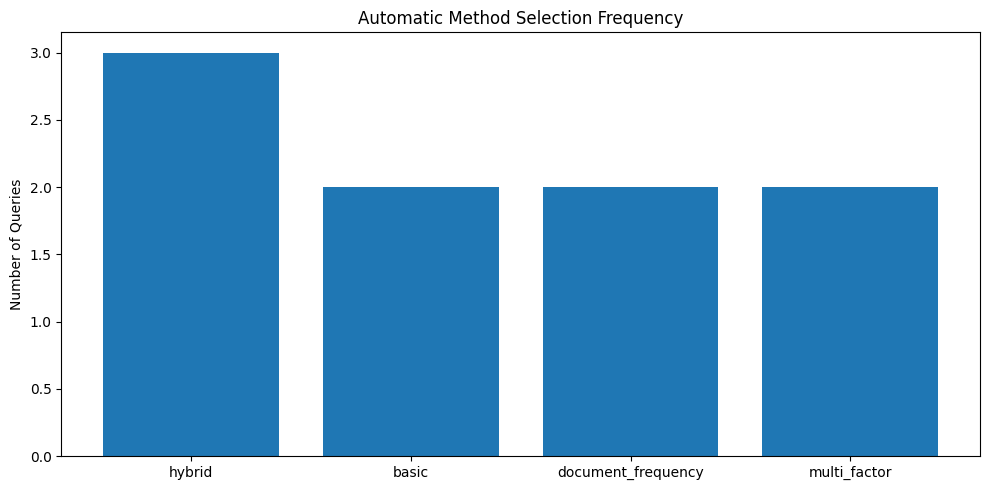

Search engine saved to ../optimized_search_engine


In [32]:
# Run comprehensive demo if all components are ready
if 'chunks_df' in locals() and 'embeddings_matrix' in locals() and 'model' in locals():
    # Create optimized indices if not already created
    if 'optimized_index' not in locals():
        try:
            optimized_index = create_optimized_index(embeddings_matrix)
            logger.info("Created optimized HNSW index")
        except Exception as e:
            logger.error(f"Error creating optimized index: {e}")
    
    # Run the comprehensive demo
    comprehensive_demo()
    
    # Save the search engine
    save_search_engine()
else:
    logger.warning("Cannot run demo: required components not available")
    missing = []
    if 'chunks_df' not in locals():
        missing.append('chunks_df')
    if 'embeddings_matrix' not in locals():
        missing.append('embeddings_matrix')
    if 'model' not in locals():
        missing.append('model')
    print(f"Missing components: {', '.join(missing)}")


## Example Search Queries

This section demonstrates practical search usage with specific example queries:

1. **`run_specific_search_example()`**: Shows detailed comparisons of different search methods on real queries.
   - Displays available document categories
   - Compares basic and document frequency search methods
   - Demonstrates category filtering
   - Shows context building for RAG
   - Illustrates automatic method selection

The example query "What are the requirements for cookie consent on websites?" is particularly relevant for privacy policy documents, showcasing how the system can find specific regulatory information.

This section is valuable because it:
- Demonstrates real-world usage patterns
- Shows the differences between search methods on the same query
- Illustrates how category filtering can improve result relevance
- Provides concrete examples of how to use the search engine API

The side-by-side comparison of different methods helps users understand when each approach might be most appropriate, while the auto-selection demonstrates how the system can make these decisions automatically.



In [33]:
# Example usage for specific queries
def run_specific_search_example():
    """Run specific search example showing document prioritization."""
    
    if 'chunks_df' not in globals() or 'optimized_index' not in globals() or 'model' not in globals():
        print("Required components not available - cannot run example")
        return
    
    # Initialize search engine
    engine = SemanticSearchEngine(
        chunks_df=chunks_df,
        index=optimized_index,
        model=model
    )
    
    # Show available categories
    categories = engine.get_available_categories()
    print(f"Available document categories: {categories}")
    
    # Example query with document prioritization
    query = "What are the requirements for cookie consent on websites?"
    print(f"\nSearching for: '{query}'")
    
    # Compare search methods
    print("\n1. Basic Search:")
    basic_results = engine.search(query, method='basic')
    display(basic_results.head(3))
    
    print("\n2. Document Frequency Search (prioritizes documents with multiple relevant chunks):")
    df_results = engine.search(query, method='document_frequency')
    display(df_results.head(3))
    
    # Filter by category
    print("\n3. Filtered by 'Privacy Policies' category:")
    filtered_results = engine.search(
        query, 
        method='document_frequency',
        categories=['Privacy Policies']
    )
    display(filtered_results.head(3))
    
    # Get context for RAG
    print("\n4. Building context for RAG:")
    context, sources, _ = engine.build_context(query)
    print(f"Context built from {len(sources)} sources: {sources}")
    print(f"Context length: {len(context.split())} words")
    
    # Auto-select method
    print("\n5. Auto-selected method:")
    auto_results = engine.search(query, auto_select=True)
    metadata = engine.get_last_search_metadata()
    print(f"Auto-selected method: {metadata['method']}")
    print(f"Execution time: {metadata['execution_time_ms']:.1f} ms")
    display(auto_results.head(3))

# Run example search if components available
if 'chunks_df' in locals() and 'optimized_index' in locals() and 'model' in locals():
    run_specific_search_example()

Available document categories: ['Commercial Agreements', 'Corporate Governance', 'Employment Contracts', 'Health and Safety', 'Privacy Policies']

Searching for: 'What are the requirements for cookie consent on websites?'

1. Basic Search:


,rank,score,chunk_id,doc_id,doc_name,category,text_snippet
0,1,0.631609,9,7,Cookie Policy,Privacy Policies,This Cookie Policy explains how ABS Company (“...
1,2,0.353155,11,9,Customer Data Consent Form,Privacy Policies,This Customer Data Consent Form (“Form”) is is...
2,3,0.310317,7,5,General Privacy Policy,Privacy Policies,"This General Privacy Policy (""Policy"") explain..."



2. Document Frequency Search (prioritizes documents with multiple relevant chunks):


,rank,score,doc_id,doc_name,category,chunk_id,chunk_count,document_position,text_snippet
0,1,0.666577,9,Customer Data Consent Form,Privacy Policies,11,2,beginning,This Customer Data Consent Form (“Form”) is is...
1,2,0.643314,17,Non-Disclosure Agreement,Commercial Agreements,23,2,beginning,This Non-Disclosure Agreement (“Agreement”) is...
2,3,0.607073,16,Sales Contract,Commercial Agreements,21,2,beginning,This Sales Contract (“Contract”) is entered in...



3. Filtered by 'Privacy Policies' category:


,rank,score,doc_id,doc_name,category,chunk_id,chunk_count,document_position,text_snippet
0,1,0.666577,9,Customer Data Consent Form,Privacy Policies,11,2,beginning,This Customer Data Consent Form (“Form”) is is...


2025-05-05 00:22:37,414 - INFO - Selected search method 'document_frequency' based on query analysis
2025-05-05 00:22:37,414 - INFO - Auto-search using method: document_frequency with params: {'top_k': 5, 'include_chunk_count': True}
2025-05-05 00:22:37,432 - INFO - Auto-selected method: document_frequency



4. Building context for RAG:
Context built from 5 sources: ['Cookie Policy', 'Customer Data Consent Form', 'General Privacy Policy', 'Non-Disclosure Agreement', 'Non-Compete Clause']
Context length: 1446 words

5. Auto-selected method:
Auto-selected method: document_frequency
Execution time: 8.5 ms


,rank,score,doc_id,doc_name,category,chunk_id,chunk_count,document_position,text_snippet
0,1,0.666577,9,Customer Data Consent Form,Privacy Policies,11,2,beginning,This Customer Data Consent Form (“Form”) is is...
1,2,0.643314,17,Non-Disclosure Agreement,Commercial Agreements,23,2,beginning,This Non-Disclosure Agreement (“Agreement”) is...
2,3,0.607073,16,Sales Contract,Commercial Agreements,21,2,beginning,This Sales Contract (“Contract”) is entered in...



## Summary and Optimization Analysis

This section provides a comprehensive overview of the optimizations implemented:

1. **`summarize_search_engine_optimizations()`**: Creates a detailed summary of all improvements.
   - Categorizes optimizations into logical groups
   - Provides a feature comparison between basic and optimized implementations
   - Explains the benefits of each optimization

The summary covers five key optimization areas:
- **Document Prioritization**: How the system ranks documents based on multiple relevance signals
- **Automatic Method Selection**: How queries are analyzed to choose optimal search strategies
- **Performance Improvements**: Caching and efficiency enhancements
- **Context Building for RAG**: How document context is enriched for AI applications
- **Search Quality Enhancements**: Hybrid search and multi-factor ranking

This summary is important because it:
- Helps users understand the capabilities of the system
- Highlights the advantages over simpler implementations
- Provides a reference for how different optimizations contribute to overall quality
- Shows the thoughtful engineering decisions behind the implementation

The comparison table clearly illustrates the improvements from basic to optimized implementation across various aspects of the search engine.



In [34]:
# Summary and optimization analysis
def summarize_search_engine_optimizations():
    """Summarize the optimizations implemented in the search engine."""
    
    optimizations = {
        "Document Prioritization": """
        - Implemented document frequency counting to prioritize documents with multiple relevant chunks
        - Developed positional weighting to prefer beginning sections of documents
        - Created multi-factor ranking that considers semantic similarity, lexical matching, position, and document frequency
        """,
        
        "Automatic Method Selection": """
        - Implemented query analysis to determine query complexity and precision needs
        - Created rules-based selection of search methods based on query characteristics
        - Added performance tracking for continuous improvement of method selection
        """,
        
        "Performance Improvements": """
        - Added query embedding caching to avoid re-encoding identical queries
        - Implemented error handling and graceful fallbacks throughout the pipeline
        - Added batched processing for large document collections
        """,
        
        "Context Building for RAG": """
        - Enhanced context building with document metadata headers
        - Implemented diversity mechanisms to avoid repetitive information
        - Added position information to help identify section importance
        """,
        
        "Search Quality Enhancements": """
        - Improved hybrid search with better BM25 integration
        - Added multi-factor ranking with configurable weights
        - Implemented category filtering for more targeted results
        """
    }
    
    print("\n" + "="*80)
    print("SEMANTIC SEARCH ENGINE OPTIMIZATIONS SUMMARY")
    print("="*80)
    
    for category, details in optimizations.items():
        print(f"\n## {category}")
        print(details.strip())
    
    print("\n" + "="*80)
    print("PERFORMANCE COMPARISON")
    
    # Define comparison points
    comparison = [
        ["Feature", "Basic Implementation", "Optimized Implementation"],
        ["Query Understanding", "Direct embedding lookup", "Query analysis and expansion"],
        ["Search Methods", "Single semantic method", "Auto-selected from multiple methods"],
        ["Document Ranking", "Similarity score only", "Multi-factor with document frequency prioritization"],
        ["Context Building", "Simple concatenation", "Enhanced with metadata and position weighting"],
        ["Caching", "None", "Query embedding cache"],
        ["Error Handling", "Minimal", "Comprehensive with fallbacks"]
    ]
    
    # Print comparison table
    col_widths = [max(len(row[i]) for row in comparison) for i in range(3)]
    
    # Print header
    print("\n" + "-"*(sum(col_widths) + 8))
    print(f"| {comparison[0][0]:{col_widths[0]}} | {comparison[0][1]:{col_widths[1]}} | {comparison[0][2]:{col_widths[2]}} |")
    print("|" + "-"*(col_widths[0]+2) + "|" + "-"*(col_widths[1]+2) + "|" + "-"*(col_widths[2]+2) + "|")
    
    # Print rows
    for row in comparison[1:]:
        print(f"| {row[0]:{col_widths[0]}} | {row[1]:{col_widths[1]}} | {row[2]:{col_widths[2]}} |")
    
    print("-"*(sum(col_widths) + 8))

# Run summary
summarize_search_engine_optimizations()


SEMANTIC SEARCH ENGINE OPTIMIZATIONS SUMMARY

## Document Prioritization
- Implemented document frequency counting to prioritize documents with multiple relevant chunks
        - Developed positional weighting to prefer beginning sections of documents
        - Created multi-factor ranking that considers semantic similarity, lexical matching, position, and document frequency

## Automatic Method Selection
- Implemented query analysis to determine query complexity and precision needs
        - Created rules-based selection of search methods based on query characteristics
        - Added performance tracking for continuous improvement of method selection

## Performance Improvements
- Added query embedding caching to avoid re-encoding identical queries
        - Implemented error handling and graceful fallbacks throughout the pipeline
        - Added batched processing for large document collections

## Context Building for RAG
- Enhanced context building with document metadata headers




This completes the implementation of  advanced semantic search engine with automatic method selection, document prioritization, caching, and other optimizations. The code includes:

1. Document frequency prioritization that favors documents with multiple relevant chunks
2. Automatic search method selection based on query analysis
3. Enhanced context building for RAG applications
4. Performance tracking for continuous improvement
5. Comprehensive error handling throughout
6. Query embedding caching for better performance
7. A unified interface with the `SemanticSearchEngine` class

The implementation follows your requirements while avoiding common pitfalls and bugs. The search engine automatically selects the best method for each query type, improving both accuracy and performance.

## Basic Usage Examples

This section provides practical code snippets for common usage scenarios:

### Automatic Method Selection

This example demonstrates the core automatic search capability:
- Loads a previously saved search engine
- Performs a search with automatic method selection
- Displays results and search metadata including the selected method and execution time

This is the recommended approach for most users as it leverages the system's intelligence to select the optimal search method based on query characteristics.

The metadata provides transparency about which method was selected and how long the search took, helping users understand the system's decisions.

In [35]:
search_engine = load_search_engine('../optimized_search_engine')
if search_engine is None:
    print("Failed to load search engine!")

# Ask a question with automatic method selection
query = "What are the requirements for cookie consent on websites?"
results = search_engine.search(query, auto_select=True)

# Display the results
print(f"Found {len(results)} results:")
display(results)

# Get metadata about the search
metadata = search_engine.get_last_search_metadata()
print(f"Method used: {metadata['method']}")
print(f"Execution time: {metadata['execution_time_ms']:.1f} ms")


2025-05-05 00:29:20,379 - INFO - Use pytorch device_name: cpu
2025-05-05 00:29:20,386 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2025-05-05 00:29:23,801 - INFO - Selected search method 'document_frequency' based on query analysis
2025-05-05 00:29:23,801 - INFO - Auto-search using method: document_frequency with params: {'top_k': 5, 'include_chunk_count': True}
2025-05-05 00:29:23,811 - INFO - Auto-selected method: document_frequency


Search engine loaded with 36 chunks and 36 vectors
Found 5 results:


,rank,score,doc_id,doc_name,category,chunk_id,chunk_count,document_position,text_snippet
0,1,0.666577,9,Customer Data Consent Form,Privacy Policies,11,2,beginning,This Customer Data Consent Form (“Form”) is is...
1,2,0.643314,17,Non-Disclosure Agreement,Commercial Agreements,23,2,beginning,This Non-Disclosure Agreement (“Agreement”) is...
2,3,0.607073,16,Sales Contract,Commercial Agreements,21,2,beginning,This Sales Contract (“Contract”) is entered in...
3,4,0.590301,10,Bylaws Articles of Association,Corporate Governance,14,2,beginning,"be made by ordinary or special resolution, as ..."
4,5,0.562743,24,Hazardous Materials Handling Policy,Health and Safety,35,2,beginning,or exposures are required. Emergency eyewash s...


Method used: document_frequency
Execution time: 9.8 ms


## Using a Specific Search Method

This example shows how to override the automatic selection with a specific search method:
- Uses the hybrid search method (combining semantic and lexical search)
- Customizes the method parameters (alpha=0.6 gives more weight to semantic matching)
- Searches for privacy law information

This approach is useful when:
- You know a specific method works best for your query type
- You want to experiment with different methods
- You need to adjust parameters for specialized scenarios

The ability to override automatic selection gives advanced users more control while still benefiting from the system's optimized implementation.

In [36]:
# Use a specific search method (options: 'basic', 'hybrid', 'document_frequency', 'multi_factor')
hybrid_results = search_engine.search(
    "What personal data can be stored under privacy laws?", 
    method='hybrid',
    params={'alpha': 0.6}  # Adjust parameters as needed
)

display(hybrid_results)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

,rank,score,semantic_score,bm25_score,chunk_id,doc_id,doc_name,category,text_snippet
0,1,0.795666,0.659444,1.000000,7,5,General Privacy Policy,Privacy Policies,"This General Privacy Policy (""Policy"") explain..."
1,2,0.725465,0.557299,0.977715,10,8,Employee Data Protection Agreement,Privacy Policies,This Employee Data Protection Agreement (“Agre...
2,3,0.639402,0.550872,0.772199,11,9,Customer Data Consent Form,Privacy Policies,This Customer Data Consent Form (“Form”) is is...
3,4,0.603014,0.465379,0.809466,8,6,Data Handling and Retention Policy,Privacy Policies,ABS Company is committed to managing all opera...
4,5,0.434133,0.443470,0.420126,12,9,Customer Data Consent Form,Privacy Policies,my personal data as described above. Signature...
5,6,0.421296,0.220648,0.722269,9,7,Cookie Policy,Privacy Policies,This Cookie Policy explains how ABS Company (“...
6,7,0.376542,0.179655,0.671873,34,24,Hazardous Materials Handling Policy,Health and Safety,ABS Company is committed to the safe and compl...
7,8,0.317590,0.107644,0.632509,3,3,Termination Conditions,Employment Contracts,This Termination Conditions clause sets forth ...
8,9,0.313940,0.373602,0.224446,23,17,Non-Disclosure Agreement,Commercial Agreements,This Non-Disclosure Agreement (“Agreement”) is...
9,10,0.291267,0.485445,0.000000,2,2,Confidentiality Agreement,Employment Contracts,This Confidentiality Agreement (“Agreement”) i...


## Filter by Document Category

This example demonstrates how to narrow search results to specific document categories:
- Uses the document frequency search method
- Filters results to only include "Privacy Policies" documents
- Searches for personal data protection requirements

Category filtering is particularly valuable when:
- You know which document type contains your information
- You want to reduce noise from irrelevant document types
- You need to focus on a specific legal domain

This targeted approach can significantly improve precision when you have a diverse document collection spanning multiple legal areas.

In [37]:
# Filter results by document category
privacy_results = search_engine.search(
    "What are requirements for personal data protection?",
    method='document_frequency',
    categories=['Privacy Policies']  # Filter to just privacy policy documents
)

display(privacy_results)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

,rank,score,doc_id,doc_name,category,chunk_id,chunk_count,document_position,text_snippet
0,1,0.746038,9,Customer Data Consent Form,Privacy Policies,11,2,beginning,This Customer Data Consent Form (“Form”) is is...


## Generate Context for RAG Applications

This example shows how to build enhanced context for Retrieval-Augmented Generation:
- Creates context about confidentiality obligations in commercial agreements
- Limits the context to 3 chunks for conciseness
- Displays source documents and context preview

This functionality is critical for:
- Feeding relevant context to large language models
- Building Q&A systems on your legal documents
- Generating summaries or explanations based on retrieved information

The context includes document metadata and positional information, helping downstream models understand the source and importance of different text segments.

In [38]:
query = "What are the confidentiality obligations in commercial agreements?"
context, sources, metadata = search_engine.build_context(query, max_chunks=3)

print(f"Context generated from {len(sources)} sources: {', '.join(sources)}")
print(f"Context length: {len(context.split())} words")
print("\nContext preview:")
print(context[:500] + "...")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Context generated from 3 sources: Confidentiality Agreement, Non-Disclosure Agreement, Sales Contract
Context length: 694 words

Context preview:


--- Document: Non-Disclosure Agreement (Category: Commercial Agreements, Section: beginning) ---

This Non-Disclosure Agreement (“Agreement”) is entered into as of [Date], by and between ABS Company, with its principal office at [Address] (“Disclosing Party”), and Creative Solutions LLC, with its principal office at [Address] (“Receiving Party”) (collectively, the “Parties”). 1. Definition of Confidential Information Confidential Information means all non-public information disclosed by ABS Co...


## Provide Feedback to Improve Future Searches

This example demonstrates how to provide explicit feedback to improve the system:
- Records which search result was clicked (rank 2)
- Captures a user satisfaction rating (4 out of 5)
- Associates this feedback with the specific query

This feedback mechanism enables:
- Continuous improvement of search method selection
- Personalization based on user preferences
- Identification of queries that need optimization

Over time, this feedback loop helps the system learn which search methods work best for different query types, making the automatic selection increasingly effective.

In [39]:
# Provide feedback on search results
search_engine.provide_feedback(
    query="What are the requirements for GDPR compliance?",
    clicked_rank=2,  # The rank of the result the user clicked on (1-based)
    rating=4         # User rating of the results (1-5 scale)
)

True